# EDA, Cleaning and Preprocessing Data for Modeling

In [116]:
import re
import os

import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [117]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000) 

In [118]:
accepted = pd.read_csv('accepted.csv')
rejected = pd.read_csv('rejected.csv')

## EDA

Data Dictionary: https://www.kaggle.com/datasets/jonchan2003/lending-club-data-dictionary

In [119]:
print(accepted.shape)
print(rejected.shape)

(2260701, 151)
(27648741, 9)


In [120]:
accepted.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,68407277,NaN,3600.0,3600.0,3600.0,36 months,13.99,123.03,C,C4,leadman,10+ years,MORTGAGE,55000.0,Not Verified,Dec-2015,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,debt_consolidation,Debt consolidation,190xx,PA,5.91,0.0,Aug-2003,675.0,679.0,1.0,30.0,NaN,7.0,0.0,2765.0,29.7,13.0,w,0.00,0.00,4421.723917,4421.72,3600.00,821.72,0.0,0.0,0.0,Jan-2019,122.67,NaN,Mar-2019,564.0,560.0,0.0,30.0,1.0,Individual,NaN,NaN,NaN,0.0,722.0,144904.0,2.0,2.0,0.0,1.0,21.0,4981.0,36.0,3.0,3.0,722.0,34.0,9300.0,3.0,1.0,4.0,4.0,20701.0,1506.0,37.2,0.0,0.0,148.0,128.0,3.0,3.0,1.0,4.0,69.0,4.0,69.0,2.0,2.0,4.0,2.0,5.0,3.0,4.0,9.0,4.0,7.0,0.0,0.0,0.0,3.0,76.9,0.0,0.0,0.0,178050.0,7746.0,2400.0,13734.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,68355089,NaN,24700.0,24700.0,24700.0,36 months,11.99,820.28,C,C1,Engineer,10+ years,MORTGAGE,65000.0,Not Verified,Dec-2015,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,small_business,Business,577xx,SD,16.06,1.0,Dec-1999,715.0,719.0,4.0,6.0,NaN,22.0,0.0,21470.0,19.2,38.0,w,0.00,0.00,25679.660000,25679.66,24700.00,979.66,0.0,0.0,0.0,Jun-2016,926.35,NaN,Mar-2019,699.0,695.0,0.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,0.0,204396.0,1.0,1.0,0.0,1.0,19.0,18005.0,73.0,2.0,3.0,6472.0,29.0,111800.0,0.0,0.0,6.0,4.0,9733.0,57830.0,27.1,0.0,0.0,113.0,192.0,2.0,2.0,4.0,2.0,NaN,0.0,6.0,0.0,5.0,5.0,13.0,17.0,6.0,20.0,27.0,5.0,22.0,0.0,0.0,0.0,2.0,97.4,7.7,0.0,0.0,314017.0,39475.0,79300.0,24667.0,NaN,NaN,NaN,NaN,NaN,N

In [121]:
rejected.head()

,Amount Requested,Application Date,Loan Title,Risk_Score,Debt-To-Income Ratio,Zip Code,State,Employment Length,Policy Code
0,1000.0,2007-05-26,Wedding Covered but No Honeymoon,693.0,10%,481xx,NM,4 years,0.0
1,1000.0,2007-05-26,Consolidating Debt,703.0,10%,010xx,MA,< 1 year,0.0
2,11000.0,2007-05-27,Want to consolidate my debt,715.0,10%,212xx,MD,1 year,0.0
3,6000.0,2007-05-27,waksman,698.0,38.64%,017xx,MA,< 1 year,0.0
4,1500.0,2007-05-27,mdrigo,509.0,9.43%,209xx,MD,< 1 year,0.0


Looking at the datasets, we only need accepted loans to predict whether a loan is going to be default or not.

## Columns with Over 10% Null Values

In [122]:
print(accepted.isna().sum().sum())

108486249


In [123]:
percent_missing_a = accepted.isnull().sum() * 100 / len(accepted)
missing_values_a = pd.DataFrame({'column_name': accepted.columns,
                                 'percent_missing': percent_missing_a})

In [124]:
missing_values_a.sort_values(by=['percent_missing'], ascending=False)

,column_name,percent_missing
member_id,member_id,100.000000
orig_projected_additional_accrued_interest,orig_projected_additional_accrued_interest,99.617331
hardship_end_date,hardship_end_date,99.517097
hardship_start_date,hardship_start_date,99.517097
hardship_type,hardship_type,99.517097
hardship_reason,hardship_reason,99.517097
hardship_status,hardship_status,99.517097
deferral_term,deferral_term,99.517097
hardship_last_payment_amount,hardship_last_payment_amount,99.517097
hardship_payoff_balance_amount,hardship_payoff_balance_amount,99.517097


In [125]:
nan_percentage_a = accepted.isna().mean() * 100
columns_to_drop_a = nan_percentage_a[nan_percentage_a > 10].index.tolist()
accepted_cleaner = accepted.drop(columns=columns_to_drop_a)

In [126]:
accepted_cleaner.shape

(2260701, 92)

In [127]:
print(accepted_cleaner.isna().sum().sum())

2734063


## Duplicates

In [128]:
accepted_cleaner.duplicated().sum()

0

We have no duplicated rows!!

## Redundant Columns / Bad Data 

In [129]:
accepted_cleaner.head()

,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,disbursement_method,debt_settlement_flag
0,68407277,3600.0,3600.0,3600.0,36 months,13.99,123.03,C,C4,leadman,10+ years,MORTGAGE,55000.0,Not Verified,Dec-2015,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,debt_consolidation,Debt consolidation,190xx,PA,5.91,0.0,Aug-2003,675.0,679.0,1.0,7.0,0.0,2765.0,29.7,13.0,w,0.00,0.00,4421.723917,4421.72,3600.00,821.72,0.0,0.0,0.0,Jan-2019,122.67,Mar-2019,564.0,560.0,0.0,1.0,Individual,0.0,722.0,144904.0,9300.0,4.0,20701.0,1506.0,37.2,0.0,0.0,148.0,128.0,3.0,3.0,1.0,4.0,2.0,2.0,4.0,2.0,5.0,3.0,4.0,9.0,4.0,7.0,0.0,0.0,0.0,3.0,76.9,0.0,0.0,0.0,178050.0,7746.0,2400.0,13734.0,N,Cash,N
1,68355089,24700.0,24700.0,24700.0,36 months,11.99,820.28,C,C1,Engineer,10+ years,MORTGAGE,65000.0,Not Verified,Dec-2015,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,small_business,Business,577xx,SD,16.06,1.0,Dec-1999,715.0,719.0,4.0,22.0,0.0,21470.0,19.2,38.0,w,0.00,0.00,25679.660000,25679.66,24700.00,979.66,0.0,0.0,0.0,Jun-2016,926.35,Mar-2019,699.0,695.0,0.0,1.0,Individual,0.0,0.0,204396.0,111800.0,4.0,9733.0,57830.0,27.1,0.0,0.0,113.0,192.0,2.0,2.0,4.0,2.0,0.0,5.0,5.0,13.0,17.0,6.0,20.0,27.0,5.0,22.0,0.0,0.0,0.0,2.0,97.4,7.7,0.0,0.0,314017.0,39475.0,79300.0,24667.0,N,Cash,N
2,68341763,20000.0,20000.0,20000.0,60 months,10.78,432.66,B,B4,truck driver,10+ years,MORTGAGE,63000.0,Not Verified,Dec-2015,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,home_improvement,NaN,605xx,IL,10.78,0.0,Aug-2000,695.0,699.0,0.0,6.0,0.0,7869.0,56.2,18.0,w,0.00,0.00,22705.924294,22705.92,20000.00,2705.92,0.0,0.0,0.0,Jun-2017,15813.30,Mar-2019,704.0,700.0,0.0,1.0,Joint App,0.0,0.0,189699.0,14000.0,6.0,31617.0,2737.0,55.9,0.0,0.0,125.0,184.0,14.0,14.0,5.0,101.0,0.0,2.0,3.0,2.0,4.0,6.0,4.0,7.0,3.0,6.0,0.0,0.0,0.0,0.0,100.0,50.0,0.0,0.0,218418.0,18696.0,6200.0,14877.0,N,Cash,N
3,66310712,35000.0,35000.0,35000.0,60 months,14.85,829.90,C,C5,Information Systems Officer,10+ years,MORTGAGE,110000.0,Source Verified,Dec-2015,Current,n,https://lendingclub.com/browse/loanDetail.acti...,debt_consolidation,Debt consolidation,076xx,NJ,17.06,0.0,Sep-2008,785.0,789.0,0.0,13.0,0.0,7802.0,11.6,17.0,w,15897.65,15897.65,31464.010000,31464.01,19102.35,12361.66,0.0,0.0,0.0,Feb-2019,829.90,Mar-2019,679.0,675.0,0.0,1.0,Individual,0.0,0.0,301500.0,67300.0,2.0,23192.0,54962.0,12.1,0.0,0.0,36.0,87.0,2.0,2.0,1.0,2.0,0.0,4.0,5.0,8.0,10.0,2.0,10.0,13.0,5.0,13.0,0.0,0.0,0.0,1.0,100.0,0.0,0.0,0.0,381215.0,52226.0,62500.0,18000.0,N,Cash,N
4,68476807,10400.0,10400.0,10400.0,60 months,22.45,289.91,F,F1,Contract Specialist,3 years,MORTGAGE,104433.0,Source Verified,Dec-2015,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,major_purchase,Major purchase,174xx,PA,25.37

### Grade vs Sub Grade

In [130]:
accepted_cleaner['grade'].value_counts()

B    663557
C    650053
A    433027
D    324424
E    135639
F     41800
G     12168
Name: grade, dtype: int64

In [131]:
accepted_cleaner['sub_grade'].value_counts().sort_values()

G5      1568
G4      1712
G3      2094
G2      2688
G1      4106
F5      5167
F4      6124
F3      7791
F2      9305
F1     13413
E5     22671
E4     22763
E3     26708
E2     29924
E1     33573
D5     48023
D4     56896
D3     64819
A2     69562
D2     72899
A3     73184
D1     81787
A1     86790
A4     95874
A5    107617
C5    116726
B1    125341
B2    126621
C4    127115
C3    129193
C2    131116
B3    131514
B4    139793
B5    140288
C1    145903
Name: sub_grade, dtype: int64

- each subgrade adds up to the overall grade
- keep subgrade and drop grade for more precision

In [132]:
accepted_cleaner = accepted_cleaner.drop(columns='sub_grade')

In [133]:
accepted_cleaner.head()

,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,disbursement_method,debt_settlement_flag
0,68407277,3600.0,3600.0,3600.0,36 months,13.99,123.03,C,leadman,10+ years,MORTGAGE,55000.0,Not Verified,Dec-2015,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,debt_consolidation,Debt consolidation,190xx,PA,5.91,0.0,Aug-2003,675.0,679.0,1.0,7.0,0.0,2765.0,29.7,13.0,w,0.00,0.00,4421.723917,4421.72,3600.00,821.72,0.0,0.0,0.0,Jan-2019,122.67,Mar-2019,564.0,560.0,0.0,1.0,Individual,0.0,722.0,144904.0,9300.0,4.0,20701.0,1506.0,37.2,0.0,0.0,148.0,128.0,3.0,3.0,1.0,4.0,2.0,2.0,4.0,2.0,5.0,3.0,4.0,9.0,4.0,7.0,0.0,0.0,0.0,3.0,76.9,0.0,0.0,0.0,178050.0,7746.0,2400.0,13734.0,N,Cash,N
1,68355089,24700.0,24700.0,24700.0,36 months,11.99,820.28,C,Engineer,10+ years,MORTGAGE,65000.0,Not Verified,Dec-2015,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,small_business,Business,577xx,SD,16.06,1.0,Dec-1999,715.0,719.0,4.0,22.0,0.0,21470.0,19.2,38.0,w,0.00,0.00,25679.660000,25679.66,24700.00,979.66,0.0,0.0,0.0,Jun-2016,926.35,Mar-2019,699.0,695.0,0.0,1.0,Individual,0.0,0.0,204396.0,111800.0,4.0,9733.0,57830.0,27.1,0.0,0.0,113.0,192.0,2.0,2.0,4.0,2.0,0.0,5.0,5.0,13.0,17.0,6.0,20.0,27.0,5.0,22.0,0.0,0.0,0.0,2.0,97.4,7.7,0.0,0.0,314017.0,39475.0,79300.0,24667.0,N,Cash,N
2,68341763,20000.0,20000.0,20000.0,60 months,10.78,432.66,B,truck driver,10+ years,MORTGAGE,63000.0,Not Verified,Dec-2015,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,home_improvement,NaN,605xx,IL,10.78,0.0,Aug-2000,695.0,699.0,0.0,6.0,0.0,7869.0,56.2,18.0,w,0.00,0.00,22705.924294,22705.92,20000.00,2705.92,0.0,0.0,0.0,Jun-2017,15813.30,Mar-2019,704.0,700.0,0.0,1.0,Joint App,0.0,0.0,189699.0,14000.0,6.0,31617.0,2737.0,55.9,0.0,0.0,125.0,184.0,14.0,14.0,5.0,101.0,0.0,2.0,3.0,2.0,4.0,6.0,4.0,7.0,3.0,6.0,0.0,0.0,0.0,0.0,100.0,50.0,0.0,0.0,218418.0,18696.0,6200.0,14877.0,N,Cash,N
3,66310712,35000.0,35000.0,35000.0,60 months,14.85,829.90,C,Information Systems Officer,10+ years,MORTGAGE,110000.0,Source Verified,Dec-2015,Current,n,https://lendingclub.com/browse/loanDetail.acti...,debt_consolidation,Debt consolidation,076xx,NJ,17.06,0.0,Sep-2008,785.0,789.0,0.0,13.0,0.0,7802.0,11.6,17.0,w,15897.65,15897.65,31464.010000,31464.01,19102.35,12361.66,0.0,0.0,0.0,Feb-2019,829.90,Mar-2019,679.0,675.0,0.0,1.0,Individual,0.0,0.0,301500.0,67300.0,2.0,23192.0,54962.0,12.1,0.0,0.0,36.0,87.0,2.0,2.0,1.0,2.0,0.0,4.0,5.0,8.0,10.0,2.0,10.0,13.0,5.0,13.0,0.0,0.0,0.0,1.0,100.0,0.0,0.0,0.0,381215.0,52226.0,62500.0,18000.0,N,Cash,N
4,68476807,10400.0,10400.0,10400.0,60 months,22.45,289.91,F,Contract Specialist,3 years,MORTGAGE,104433.0,Source Verified,Dec-2015,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,major_purchase,Major purchase,174xx,PA,25.37,1.0,Jun-1998,695.0,699.0

### URL

In [20]:
accepted_cleaner['url'].value_counts()

https://lendingclub.com/browse/loanDetail.action?loan_id=68407277     1
https://lendingclub.com/browse/loanDetail.action?loan_id=134288565    1
https://lendingclub.com/browse/loanDetail.action?loan_id=134898754    1
https://lendingclub.com/browse/loanDetail.action?loan_id=134545653    1
https://lendingclub.com/browse/loanDetail.action?loan_id=134958365    1
                                                                     ..
https://lendingclub.com/browse/loanDetail.action?loan_id=140949487    1
https://lendingclub.com/browse/loanDetail.action?loan_id=140883098    1
https://lendingclub.com/browse/loanDetail.action?loan_id=140058652    1
https://lendingclub.com/browse/loanDetail.action?loan_id=140241108    1
https://lendingclub.com/browse/loanDetail.action?loan_id=88215728     1
Name: url, Length: 2260668, dtype: int64

URL has no prediction value on the outcome of a loan so we are dropping it.

In [21]:
accepted_cleaner = accepted_cleaner.drop(columns='url')

In [22]:
accepted_cleaner.head()

,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,disbursement_method,debt_settlement_flag
0,68407277,3600.0,3600.0,3600.0,36 months,13.99,123.03,C,leadman,10+ years,MORTGAGE,55000.0,Not Verified,Dec-2015,Fully Paid,n,debt_consolidation,Debt consolidation,190xx,PA,5.91,0.0,Aug-2003,675.0,679.0,1.0,7.0,0.0,2765.0,29.7,13.0,w,0.00,0.00,4421.723917,4421.72,3600.00,821.72,0.0,0.0,0.0,Jan-2019,122.67,Mar-2019,564.0,560.0,0.0,1.0,Individual,0.0,722.0,144904.0,9300.0,4.0,20701.0,1506.0,37.2,0.0,0.0,148.0,128.0,3.0,3.0,1.0,4.0,2.0,2.0,4.0,2.0,5.0,3.0,4.0,9.0,4.0,7.0,0.0,0.0,0.0,3.0,76.9,0.0,0.0,0.0,178050.0,7746.0,2400.0,13734.0,N,Cash,N
1,68355089,24700.0,24700.0,24700.0,36 months,11.99,820.28,C,Engineer,10+ years,MORTGAGE,65000.0,Not Verified,Dec-2015,Fully Paid,n,small_business,Business,577xx,SD,16.06,1.0,Dec-1999,715.0,719.0,4.0,22.0,0.0,21470.0,19.2,38.0,w,0.00,0.00,25679.660000,25679.66,24700.00,979.66,0.0,0.0,0.0,Jun-2016,926.35,Mar-2019,699.0,695.0,0.0,1.0,Individual,0.0,0.0,204396.0,111800.0,4.0,9733.0,57830.0,27.1,0.0,0.0,113.0,192.0,2.0,2.0,4.0,2.0,0.0,5.0,5.0,13.0,17.0,6.0,20.0,27.0,5.0,22.0,0.0,0.0,0.0,2.0,97.4,7.7,0.0,0.0,314017.0,39475.0,79300.0,24667.0,N,Cash,N
2,68341763,20000.0,20000.0,20000.0,60 months,10.78,432.66,B,truck driver,10+ years,MORTGAGE,63000.0,Not Verified,Dec-2015,Fully Paid,n,home_improvement,NaN,605xx,IL,10.78,0.0,Aug-2000,695.0,699.0,0.0,6.0,0.0,7869.0,56.2,18.0,w,0.00,0.00,22705.924294,22705.92,20000.00,2705.92,0.0,0.0,0.0,Jun-2017,15813.30,Mar-2019,704.0,700.0,0.0,1.0,Joint App,0.0,0.0,189699.0,14000.0,6.0,31617.0,2737.0,55.9,0.0,0.0,125.0,184.0,14.0,14.0,5.0,101.0,0.0,2.0,3.0,2.0,4.0,6.0,4.0,7.0,3.0,6.0,0.0,0.0,0.0,0.0,100.0,50.0,0.0,0.0,218418.0,18696.0,6200.0,14877.0,N,Cash,N
3,66310712,35000.0,35000.0,35000.0,60 months,14.85,829.90,C,Information Systems Officer,10+ years,MORTGAGE,110000.0,Source Verified,Dec-2015,Current,n,debt_consolidation,Debt consolidation,076xx,NJ,17.06,0.0,Sep-2008,785.0,789.0,0.0,13.0,0.0,7802.0,11.6,17.0,w,15897.65,15897.65,31464.010000,31464.01,19102.35,12361.66,0.0,0.0,0.0,Feb-2019,829.90,Mar-2019,679.0,675.0,0.0,1.0,Individual,0.0,0.0,301500.0,67300.0,2.0,23192.0,54962.0,12.1,0.0,0.0,36.0,87.0,2.0,2.0,1.0,2.0,0.0,4.0,5.0,8.0,10.0,2.0,10.0,13.0,5.0,13.0,0.0,0.0,0.0,1.0,100.0,0.0,0.0,0.0,381215.0,52226.0,62500.0,18000.0,N,Cash,N
4,68476807,10400.0,10400.0,10400.0,60 months,22.45,289.91,F,Contract Specialist,3 years,MORTGAGE,104433.0,Source Verified,Dec-2015,Fully Paid,n,major_purchase,Major purchase,174xx,PA,25.37,1.0,Jun-1998,695.0,699.0,3.0,12.0,0.0,21929.0,64.5,35.0,w,0.00,0.00,11740.500000,11740.50,10400.00,1340.50,0.0,0.0,0.0,Jul-2016,10128.96,Mar-2018,704.0,700.0,0.0,1.0,Individual,0.0,0.0,331730.0,34000.0,10.0,27644.0,4567.0,77.5,0.0,0.0,128.0,210.0,4.0,4.0,6.0,4.0,0.0,4.0,6.0,5.0

### Purpose vs Title

In [23]:
accepted_cleaner['purpose'].value_counts()

debt_consolidation    1277877
credit_card            516971
home_improvement       150457
other                  139440
major_purchase          50445
medical                 27488
small_business          24689
car                     24013
vacation                15525
moving                  15403
house                   14136
wedding                  2355
renewable_energy         1445
educational               424
Name: purpose, dtype: int64

In [24]:
accepted_cleaner['title'].value_counts().head(50)

Debt consolidation           1153293
Credit card refinancing       469691
Home improvement              137437
Other                         127714
Major purchase                 44840
Medical expenses               25388
Business                       20804
Car financing                  20526
Debt Consolidation             15763
Vacation                       14443
Moving and relocation          13800
Home buying                    12714
Consolidation                   5385
debt consolidation              4837
Debt Consolidation Loan         3804
Credit Card Consolidation       2360
consolidation                   2175
Personal Loan                   2133
Consolidation Loan              1778
Home Improvement                1773
Credit Card Refinance           1468
Credit Card Payoff              1386
Consolidate                     1268
Green loan                      1232
Personal                        1185
Loan                            1033
Freedom                          803
C

It seems that title has what the applicate of the loan has written down and the purpose is a hard selected by the company for the reason of application. We will be dropping title.

In [25]:
accepted_cleaner = accepted_cleaner.drop(columns='title')

In [26]:
accepted_cleaner.head()

,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,purpose,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,disbursement_method,debt_settlement_flag
0,68407277,3600.0,3600.0,3600.0,36 months,13.99,123.03,C,leadman,10+ years,MORTGAGE,55000.0,Not Verified,Dec-2015,Fully Paid,n,debt_consolidation,190xx,PA,5.91,0.0,Aug-2003,675.0,679.0,1.0,7.0,0.0,2765.0,29.7,13.0,w,0.00,0.00,4421.723917,4421.72,3600.00,821.72,0.0,0.0,0.0,Jan-2019,122.67,Mar-2019,564.0,560.0,0.0,1.0,Individual,0.0,722.0,144904.0,9300.0,4.0,20701.0,1506.0,37.2,0.0,0.0,148.0,128.0,3.0,3.0,1.0,4.0,2.0,2.0,4.0,2.0,5.0,3.0,4.0,9.0,4.0,7.0,0.0,0.0,0.0,3.0,76.9,0.0,0.0,0.0,178050.0,7746.0,2400.0,13734.0,N,Cash,N
1,68355089,24700.0,24700.0,24700.0,36 months,11.99,820.28,C,Engineer,10+ years,MORTGAGE,65000.0,Not Verified,Dec-2015,Fully Paid,n,small_business,577xx,SD,16.06,1.0,Dec-1999,715.0,719.0,4.0,22.0,0.0,21470.0,19.2,38.0,w,0.00,0.00,25679.660000,25679.66,24700.00,979.66,0.0,0.0,0.0,Jun-2016,926.35,Mar-2019,699.0,695.0,0.0,1.0,Individual,0.0,0.0,204396.0,111800.0,4.0,9733.0,57830.0,27.1,0.0,0.0,113.0,192.0,2.0,2.0,4.0,2.0,0.0,5.0,5.0,13.0,17.0,6.0,20.0,27.0,5.0,22.0,0.0,0.0,0.0,2.0,97.4,7.7,0.0,0.0,314017.0,39475.0,79300.0,24667.0,N,Cash,N
2,68341763,20000.0,20000.0,20000.0,60 months,10.78,432.66,B,truck driver,10+ years,MORTGAGE,63000.0,Not Verified,Dec-2015,Fully Paid,n,home_improvement,605xx,IL,10.78,0.0,Aug-2000,695.0,699.0,0.0,6.0,0.0,7869.0,56.2,18.0,w,0.00,0.00,22705.924294,22705.92,20000.00,2705.92,0.0,0.0,0.0,Jun-2017,15813.30,Mar-2019,704.0,700.0,0.0,1.0,Joint App,0.0,0.0,189699.0,14000.0,6.0,31617.0,2737.0,55.9,0.0,0.0,125.0,184.0,14.0,14.0,5.0,101.0,0.0,2.0,3.0,2.0,4.0,6.0,4.0,7.0,3.0,6.0,0.0,0.0,0.0,0.0,100.0,50.0,0.0,0.0,218418.0,18696.0,6200.0,14877.0,N,Cash,N
3,66310712,35000.0,35000.0,35000.0,60 months,14.85,829.90,C,Information Systems Officer,10+ years,MORTGAGE,110000.0,Source Verified,Dec-2015,Current,n,debt_consolidation,076xx,NJ,17.06,0.0,Sep-2008,785.0,789.0,0.0,13.0,0.0,7802.0,11.6,17.0,w,15897.65,15897.65,31464.010000,31464.01,19102.35,12361.66,0.0,0.0,0.0,Feb-2019,829.90,Mar-2019,679.0,675.0,0.0,1.0,Individual,0.0,0.0,301500.0,67300.0,2.0,23192.0,54962.0,12.1,0.0,0.0,36.0,87.0,2.0,2.0,1.0,2.0,0.0,4.0,5.0,8.0,10.0,2.0,10.0,13.0,5.0,13.0,0.0,0.0,0.0,1.0,100.0,0.0,0.0,0.0,381215.0,52226.0,62500.0,18000.0,N,Cash,N
4,68476807,10400.0,10400.0,10400.0,60 months,22.45,289.91,F,Contract Specialist,3 years,MORTGAGE,104433.0,Source Verified,Dec-2015,Fully Paid,n,major_purchase,174xx,PA,25.37,1.0,Jun-1998,695.0,699.0,3.0,12.0,0.0,21929.0,64.5,35.0,w,0.00,0.00,11740.500000,11740.50,10400.00,1340.50,0.0,0.0,0.0,Jul-2016,10128.96,Mar-2018,704.0,700.0,0.0,1.0,Individual,0.0,0.0,331730.0,34000.0,10.0,27644.0,4567.0,77.5,0.0,0.0,128.0,210.0,4.0,4.0,6.0,4.0,0.0,4.0,6.0,5.0,9.0,10.0,7.0,19.0,6.0,12.0,0.0,0.0,0.0,4.0,96.6,60.0,0.0,0.0,439570.0,9

### Zip code 

In [27]:
accepted_cleaner['zip_code'].value_counts()

112xx    23908
945xx    23782
750xx    23649
606xx    21192
300xx    20497
         ...  
817xx        1
521xx        1
520xx        1
872xx        1
896xx        1
Name: zip_code, Length: 956, dtype: int64

All of the zip codes have an xx in place of the last two digit so this will not help us. We will drop the column.

In [28]:
accepted_cleaner = accepted_cleaner.drop(columns='zip_code')

In [29]:
accepted_cleaner.head()

,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,purpose,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,disbursement_method,debt_settlement_flag
0,68407277,3600.0,3600.0,3600.0,36 months,13.99,123.03,C,leadman,10+ years,MORTGAGE,55000.0,Not Verified,Dec-2015,Fully Paid,n,debt_consolidation,PA,5.91,0.0,Aug-2003,675.0,679.0,1.0,7.0,0.0,2765.0,29.7,13.0,w,0.00,0.00,4421.723917,4421.72,3600.00,821.72,0.0,0.0,0.0,Jan-2019,122.67,Mar-2019,564.0,560.0,0.0,1.0,Individual,0.0,722.0,144904.0,9300.0,4.0,20701.0,1506.0,37.2,0.0,0.0,148.0,128.0,3.0,3.0,1.0,4.0,2.0,2.0,4.0,2.0,5.0,3.0,4.0,9.0,4.0,7.0,0.0,0.0,0.0,3.0,76.9,0.0,0.0,0.0,178050.0,7746.0,2400.0,13734.0,N,Cash,N
1,68355089,24700.0,24700.0,24700.0,36 months,11.99,820.28,C,Engineer,10+ years,MORTGAGE,65000.0,Not Verified,Dec-2015,Fully Paid,n,small_business,SD,16.06,1.0,Dec-1999,715.0,719.0,4.0,22.0,0.0,21470.0,19.2,38.0,w,0.00,0.00,25679.660000,25679.66,24700.00,979.66,0.0,0.0,0.0,Jun-2016,926.35,Mar-2019,699.0,695.0,0.0,1.0,Individual,0.0,0.0,204396.0,111800.0,4.0,9733.0,57830.0,27.1,0.0,0.0,113.0,192.0,2.0,2.0,4.0,2.0,0.0,5.0,5.0,13.0,17.0,6.0,20.0,27.0,5.0,22.0,0.0,0.0,0.0,2.0,97.4,7.7,0.0,0.0,314017.0,39475.0,79300.0,24667.0,N,Cash,N
2,68341763,20000.0,20000.0,20000.0,60 months,10.78,432.66,B,truck driver,10+ years,MORTGAGE,63000.0,Not Verified,Dec-2015,Fully Paid,n,home_improvement,IL,10.78,0.0,Aug-2000,695.0,699.0,0.0,6.0,0.0,7869.0,56.2,18.0,w,0.00,0.00,22705.924294,22705.92,20000.00,2705.92,0.0,0.0,0.0,Jun-2017,15813.30,Mar-2019,704.0,700.0,0.0,1.0,Joint App,0.0,0.0,189699.0,14000.0,6.0,31617.0,2737.0,55.9,0.0,0.0,125.0,184.0,14.0,14.0,5.0,101.0,0.0,2.0,3.0,2.0,4.0,6.0,4.0,7.0,3.0,6.0,0.0,0.0,0.0,0.0,100.0,50.0,0.0,0.0,218418.0,18696.0,6200.0,14877.0,N,Cash,N
3,66310712,35000.0,35000.0,35000.0,60 months,14.85,829.90,C,Information Systems Officer,10+ years,MORTGAGE,110000.0,Source Verified,Dec-2015,Current,n,debt_consolidation,NJ,17.06,0.0,Sep-2008,785.0,789.0,0.0,13.0,0.0,7802.0,11.6,17.0,w,15897.65,15897.65,31464.010000,31464.01,19102.35,12361.66,0.0,0.0,0.0,Feb-2019,829.90,Mar-2019,679.0,675.0,0.0,1.0,Individual,0.0,0.0,301500.0,67300.0,2.0,23192.0,54962.0,12.1,0.0,0.0,36.0,87.0,2.0,2.0,1.0,2.0,0.0,4.0,5.0,8.0,10.0,2.0,10.0,13.0,5.0,13.0,0.0,0.0,0.0,1.0,100.0,0.0,0.0,0.0,381215.0,52226.0,62500.0,18000.0,N,Cash,N
4,68476807,10400.0,10400.0,10400.0,60 months,22.45,289.91,F,Contract Specialist,3 years,MORTGAGE,104433.0,Source Verified,Dec-2015,Fully Paid,n,major_purchase,PA,25.37,1.0,Jun-1998,695.0,699.0,3.0,12.0,0.0,21929.0,64.5,35.0,w,0.00,0.00,11740.500000,11740.50,10400.00,1340.50,0.0,0.0,0.0,Jul-2016,10128.96,Mar-2018,704.0,700.0,0.0,1.0,Individual,0.0,0.0,331730.0,34000.0,10.0,27644.0,4567.0,77.5,0.0,0.0,128.0,210.0,4.0,4.0,6.0,4.0,0.0,4.0,6.0,5.0,9.0,10.0,7.0,19.0,6.0,12.0,0.0,0.0,0.0,4.0,96.6,60.0,0.0,0.0,439570.0,95768.0,20300.0,88097.0,N,Cash,N


### Policy Code

In [30]:
accepted_cleaner['policy_code'].value_counts()

1.0    2260668
Name: policy_code, dtype: int64

Policy code only has one value in it so we will be dropping this column.

In [31]:
accepted_cleaner = accepted_cleaner.drop(columns='policy_code')

In [32]:
accepted_cleaner.head()

,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,purpose,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,disbursement_method,debt_settlement_flag
0,68407277,3600.0,3600.0,3600.0,36 months,13.99,123.03,C,leadman,10+ years,MORTGAGE,55000.0,Not Verified,Dec-2015,Fully Paid,n,debt_consolidation,PA,5.91,0.0,Aug-2003,675.0,679.0,1.0,7.0,0.0,2765.0,29.7,13.0,w,0.00,0.00,4421.723917,4421.72,3600.00,821.72,0.0,0.0,0.0,Jan-2019,122.67,Mar-2019,564.0,560.0,0.0,Individual,0.0,722.0,144904.0,9300.0,4.0,20701.0,1506.0,37.2,0.0,0.0,148.0,128.0,3.0,3.0,1.0,4.0,2.0,2.0,4.0,2.0,5.0,3.0,4.0,9.0,4.0,7.0,0.0,0.0,0.0,3.0,76.9,0.0,0.0,0.0,178050.0,7746.0,2400.0,13734.0,N,Cash,N
1,68355089,24700.0,24700.0,24700.0,36 months,11.99,820.28,C,Engineer,10+ years,MORTGAGE,65000.0,Not Verified,Dec-2015,Fully Paid,n,small_business,SD,16.06,1.0,Dec-1999,715.0,719.0,4.0,22.0,0.0,21470.0,19.2,38.0,w,0.00,0.00,25679.660000,25679.66,24700.00,979.66,0.0,0.0,0.0,Jun-2016,926.35,Mar-2019,699.0,695.0,0.0,Individual,0.0,0.0,204396.0,111800.0,4.0,9733.0,57830.0,27.1,0.0,0.0,113.0,192.0,2.0,2.0,4.0,2.0,0.0,5.0,5.0,13.0,17.0,6.0,20.0,27.0,5.0,22.0,0.0,0.0,0.0,2.0,97.4,7.7,0.0,0.0,314017.0,39475.0,79300.0,24667.0,N,Cash,N
2,68341763,20000.0,20000.0,20000.0,60 months,10.78,432.66,B,truck driver,10+ years,MORTGAGE,63000.0,Not Verified,Dec-2015,Fully Paid,n,home_improvement,IL,10.78,0.0,Aug-2000,695.0,699.0,0.0,6.0,0.0,7869.0,56.2,18.0,w,0.00,0.00,22705.924294,22705.92,20000.00,2705.92,0.0,0.0,0.0,Jun-2017,15813.30,Mar-2019,704.0,700.0,0.0,Joint App,0.0,0.0,189699.0,14000.0,6.0,31617.0,2737.0,55.9,0.0,0.0,125.0,184.0,14.0,14.0,5.0,101.0,0.0,2.0,3.0,2.0,4.0,6.0,4.0,7.0,3.0,6.0,0.0,0.0,0.0,0.0,100.0,50.0,0.0,0.0,218418.0,18696.0,6200.0,14877.0,N,Cash,N
3,66310712,35000.0,35000.0,35000.0,60 months,14.85,829.90,C,Information Systems Officer,10+ years,MORTGAGE,110000.0,Source Verified,Dec-2015,Current,n,debt_consolidation,NJ,17.06,0.0,Sep-2008,785.0,789.0,0.0,13.0,0.0,7802.0,11.6,17.0,w,15897.65,15897.65,31464.010000,31464.01,19102.35,12361.66,0.0,0.0,0.0,Feb-2019,829.90,Mar-2019,679.0,675.0,0.0,Individual,0.0,0.0,301500.0,67300.0,2.0,23192.0,54962.0,12.1,0.0,0.0,36.0,87.0,2.0,2.0,1.0,2.0,0.0,4.0,5.0,8.0,10.0,2.0,10.0,13.0,5.0,13.0,0.0,0.0,0.0,1.0,100.0,0.0,0.0,0.0,381215.0,52226.0,62500.0,18000.0,N,Cash,N
4,68476807,10400.0,10400.0,10400.0,60 months,22.45,289.91,F,Contract Specialist,3 years,MORTGAGE,104433.0,Source Verified,Dec-2015,Fully Paid,n,major_purchase,PA,25.37,1.0,Jun-1998,695.0,699.0,3.0,12.0,0.0,21929.0,64.5,35.0,w,0.00,0.00,11740.500000,11740.50,10400.00,1340.50,0.0,0.0,0.0,Jul-2016,10128.96,Mar-2018,704.0,700.0,0.0,Individual,0.0,0.0,331730.0,34000.0,10.0,27644.0,4567.0,77.5,0.0,0.0,128.0,210.0,4.0,4.0,6.0,4.0,0.0,4.0,6.0,5.0,9.0,10.0,7.0,19.0,6.0,12.0,0.0,0.0,0.0,4.0,96.6,60.0,0.0,0.0,439570.0,95768.0,20300.0,88097.0,N,Cash,N


## Target `loan_status` Column Processing

https://help.lendingclub.com/hc/en-us/articles/216109367-What-Do-the-Different-Note-Statuses-Mean-

In [134]:
accepted_cleaner['loan_status'].value_counts()

Fully Paid                                             1076751
Current                                                 878317
Charged Off                                             268559
Late (31-120 days)                                       21467
In Grace Period                                           8436
Late (16-30 days)                                         4349
Does not meet the credit policy. Status:Fully Paid        1988
Does not meet the credit policy. Status:Charged Off        761
Default                                                     40
Name: loan_status, dtype: int64

In [135]:
status_mapper = {
    'Fully Paid': 'Paid',
    'Current': 'Paid',
    'Charged Off': 'Default', 
    'Late (31-120 days)': 'Late',
    'In Grace Period': 'Late', 
    'Late (16-30 days)': 'Late', 
    'Does not meet the credit policy. Status:Fully Paid': 'Paid',
    'Does not meet the credit policy. Status:Charged Off': 'Default',
    'Default': 'Default'
}

In [136]:
accepted_cleaner['loan_status'] = accepted_cleaner['loan_status'].map(status_mapper)

We only want the default and paid loans so we are going to get rid of the late loans

In [137]:
accepted_cleaner = accepted_cleaner[ (accepted_cleaner["loan_status"]== "Paid") | (accepted_cleaner["loan_status"]== "Default")]

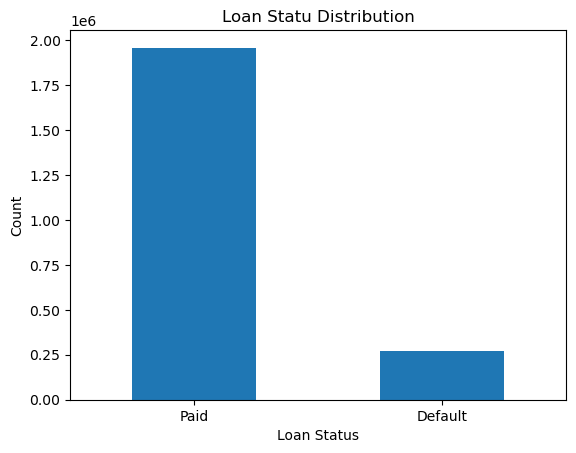

In [146]:
accepted_cleaner['loan_status'].value_counts().plot(kind='bar')
plt.title('Loan Statu Distribution')
plt.xlabel('Loan Status')
plt.ylabel('Count')
# rotate axis labels
plt.setp(plt.gca().get_xticklabels(), rotation=0, horizontalalignment='center')
plt.show()

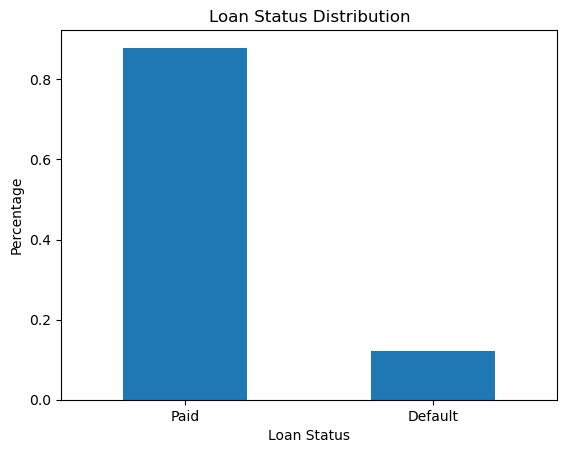

In [147]:
# plot percentage of loan status
accepted_cleaner['loan_status'].value_counts(normalize=True).plot(kind='bar')
plt.title('Loan Status Distribution')
plt.xlabel('Loan Status')
plt.ylabel('Percentage')
# rotate axis labels
plt.setp(plt.gca().get_xticklabels(), rotation=0, horizontalalignment='center')
plt.show()
    

In [38]:
accepted_cleaner['loan_status'].value_counts()

Paid       1957056
Default     269360
Name: loan_status, dtype: int64

In [39]:
269360 / 1957056

0.13763530527486184

## Split into Categorical and Numerical

In [40]:
accepted_cleaner.dtypes.value_counts()

float64    67
object     20
dtype: int64

In [41]:
categorical_df = accepted_cleaner.select_dtypes('object').copy()
categorical_df.head()

,id,term,grade,emp_title,emp_length,home_ownership,verification_status,issue_d,loan_status,pymnt_plan,purpose,addr_state,earliest_cr_line,initial_list_status,last_pymnt_d,last_credit_pull_d,application_type,hardship_flag,disbursement_method,debt_settlement_flag
0,68407277,36 months,C,leadman,10+ years,MORTGAGE,Not Verified,Dec-2015,Paid,n,debt_consolidation,PA,Aug-2003,w,Jan-2019,Mar-2019,Individual,N,Cash,N
1,68355089,36 months,C,Engineer,10+ years,MORTGAGE,Not Verified,Dec-2015,Paid,n,small_business,SD,Dec-1999,w,Jun-2016,Mar-2019,Individual,N,Cash,N
2,68341763,60 months,B,truck driver,10+ years,MORTGAGE,Not Verified,Dec-2015,Paid,n,home_improvement,IL,Aug-2000,w,Jun-2017,Mar-2019,Joint App,N,Cash,N
3,66310712,60 months,C,Information Systems Officer,10+ years,MORTGAGE,Source Verified,Dec-2015,Paid,n,debt_consolidation,NJ,Sep-2008,w,Feb-2019,Mar-2019,Individual,N,Cash,N
4,68476807,60 months,F,Contract Specialist,3 years,MORTGAGE,Source Verified,Dec-2015,Paid,n,major_purchase,PA,Jun-1998,w,Jul-2016,Mar-2018,Individual,N,Cash,N


In [42]:
numerical_df = accepted_cleaner.select_dtypes('float64').copy()
numerical_df.head()

,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,fico_range_low,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,3600.0,3600.0,3600.0,13.99,123.03,55000.0,5.91,0.0,675.0,679.0,1.0,7.0,0.0,2765.0,29.7,13.0,0.00,0.00,4421.723917,4421.72,3600.00,821.72,0.0,0.0,0.0,122.67,564.0,560.0,0.0,0.0,722.0,144904.0,9300.0,4.0,20701.0,1506.0,37.2,0.0,0.0,148.0,128.0,3.0,3.0,1.0,4.0,2.0,2.0,4.0,2.0,5.0,3.0,4.0,9.0,4.0,7.0,0.0,0.0,0.0,3.0,76.9,0.0,0.0,0.0,178050.0,7746.0,2400.0,13734.0
1,24700.0,24700.0,24700.0,11.99,820.28,65000.0,16.06,1.0,715.0,719.0,4.0,22.0,0.0,21470.0,19.2,38.0,0.00,0.00,25679.660000,25679.66,24700.00,979.66,0.0,0.0,0.0,926.35,699.0,695.0,0.0,0.0,0.0,204396.0,111800.0,4.0,9733.0,57830.0,27.1,0.0,0.0,113.0,192.0,2.0,2.0,4.0,2.0,0.0,5.0,5.0,13.0,17.0,6.0,20.0,27.0,5.0,22.0,0.0,0.0,0.0,2.0,97.4,7.7,0.0,0.0,314017.0,39475.0,79300.0,24667.0
2,20000.0,20000.0,20000.0,10.78,432.66,63000.0,10.78,0.0,695.0,699.0,0.0,6.0,0.0,7869.0,56.2,18.0,0.00,0.00,22705.924294,22705.92,20000.00,2705.92,0.0,0.0,0.0,15813.30,704.0,700.0,0.0,0.0,0.0,189699.0,14000.0,6.0,31617.0,2737.0,55.9,0.0,0.0,125.0,184.0,14.0,14.0,5.0,101.0,0.0,2.0,3.0,2.0,4.0,6.0,4.0,7.0,3.0,6.0,0.0,0.0,0.0,0.0,100.0,50.0,0.0,0.0,218418.0,18696.0,6200.0,14877.0
3,35000.0,35000.0,35000.0,14.85,829.90,110000.0,17.06,0.0,785.0,789.0,0.0,13.0,0.0,7802.0,11.6,17.0,15897.65,15897.65,31464.010000,31464.01,19102.35,12361.66,0.0,0.0,0.0,829.90,679.0,675.0,0.0,0.0,0.0,301500.0,67300.0,2.0,23192.0,54962.0,12.1,0.0,0.0,36.0,87.0,2.0,2.0,1.0,2.0,0.0,4.0,5.0,8.0,10.0,2.0,10.0,13.0,5.0,13.0,0.0,0.0,0.0,1.0,100.0,0.0,0.0,0.0,381215.0,52226.0,62500.0,18000.0
4,10400.0,10400.0,10400.0,22.45,289.91,104433.0,25.37,1.0,695.0,699.0,3.0,12.0,0.0,21929.0,64.5,35.0,0.00,0.00,11740.500000,11740.50,10400.00,1340.50,0.0,0.0,0.0,10128.96,704.0,700.0,0.0,0.0,0.0,331730.0,34000.0,10.0,27644.0,4567.0,77.5,0.0,0.0,128.0,210.0,4.0,4.0,6.0,4.0,0.0,4.0,6.0,5.0,9.0,10.0,7.0,19.0,6.0,12.0,0.0,0.0,0.0,4.0,96.6,60.0,0.0,0.0,439570.0,95768.0,20300.0,88097.0


## Chi-Square between columns and `loan status`

In [43]:
# import chi2_contingency
from scipy.stats import chi2_contingency

target_variable = 'loan_status'

for column in categorical_df.columns:
    if column != target_variable:
        
        contingency_table = pd.crosstab(categorical_df[column], categorical_df[target_variable])

        chi2, p_value, dof, expected = chi2_contingency(contingency_table)

        print(f"Chi-square test for {column} vs {target_variable}: chi2={chi2}, p-value={p_value}")

Chi-square test for id vs loan_status: chi2=2226416.0000000005, p-value=0.4996849056098685
Chi-square test for term vs loan_status: chi2=16715.613585185638, p-value=0.0
Chi-square test for grade vs loan_status: chi2=116943.39863641646, p-value=0.0
Chi-square test for emp_title vs loan_status: chi2=586441.9919945797, p-value=0.0
Chi-square test for emp_length vs loan_status: chi2=669.6711966323332, p-value=2.027991715063674e-137
Chi-square test for home_ownership vs loan_status: chi2=6189.086448745866, p-value=0.0
Chi-square test for verification_status vs loan_status: chi2=20432.596984314674, p-value=0.0
Chi-square test for issue_d vs loan_status: chi2=85294.57693204595, p-value=0.0
Chi-square test for pymnt_plan vs loan_status: chi2=0.0, p-value=1.0
Chi-square test for purpose vs loan_status: chi2=5736.725730738217, p-value=0.0
Chi-square test for addr_state vs loan_status: chi2=3298.8574525683352, p-value=0.0
Chi-square test for earliest_cr_line vs loan_status: chi2=4301.638454978651

Only id has a high p-value but since its insignificant we can drop it from out data.

In [44]:
categorical_df = categorical_df.drop(columns='id')
accepted_cleaner = accepted_cleaner.drop(columns='id')

In [45]:
accepted_cleaner.shape

(2226416, 86)

In [46]:
categorical_df.head() 

,term,grade,emp_title,emp_length,home_ownership,verification_status,issue_d,loan_status,pymnt_plan,purpose,addr_state,earliest_cr_line,initial_list_status,last_pymnt_d,last_credit_pull_d,application_type,hardship_flag,disbursement_method,debt_settlement_flag
0,36 months,C,leadman,10+ years,MORTGAGE,Not Verified,Dec-2015,Paid,n,debt_consolidation,PA,Aug-2003,w,Jan-2019,Mar-2019,Individual,N,Cash,N
1,36 months,C,Engineer,10+ years,MORTGAGE,Not Verified,Dec-2015,Paid,n,small_business,SD,Dec-1999,w,Jun-2016,Mar-2019,Individual,N,Cash,N
2,60 months,B,truck driver,10+ years,MORTGAGE,Not Verified,Dec-2015,Paid,n,home_improvement,IL,Aug-2000,w,Jun-2017,Mar-2019,Joint App,N,Cash,N
3,60 months,C,Information Systems Officer,10+ years,MORTGAGE,Source Verified,Dec-2015,Paid,n,debt_consolidation,NJ,Sep-2008,w,Feb-2019,Mar-2019,Individual,N,Cash,N
4,60 months,F,Contract Specialist,3 years,MORTGAGE,Source Verified,Dec-2015,Paid,n,major_purchase,PA,Jun-1998,w,Jul-2016,Mar-2018,Individual,N,Cash,N


## Remainder of Null Values 

In [47]:
print(accepted_cleaner.isna().sum().sum())

2696314


In [48]:
# find all rows with a null value
null_rows = accepted_cleaner[accepted_cleaner.isnull().any(axis=1)]
null_rows

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,purpose,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,disbursement_method,debt_settlement_flag
19,8650.0,8650.0,8650.0,36 months,19.89,320.99,E,Program Coordinator,8 years,RENT,55000.0,Verified,Dec-2015,Paid,n,debt_consolidation,IN,25.49,0.0,Mar-2005,675.0,679.0,4.0,18.0,1.0,9568.0,46.0,19.0,w,0.00,0.00,9190.490000,9190.49,8650.00,540.49,0.0,0.0,0.0,May-2016,8251.42,Jun-2016,639.0,635.0,0.0,Individual,0.0,0.0,18926.0,20750.0,17.0,1051.0,1375.0,45.0,0.0,0.0,129.0,95.0,0.0,0.0,0.0,8.0,0.0,2.0,17.0,2.0,2.0,2.0,17.0,17.0,13.0,18.0,NaN,0.0,0.0,12.0,100.0,50.0,1.0,0.0,38998.0,18926.0,2750.0,18248.0,N,Cash,N
55,24000.0,24000.0,24000.0,60 months,9.80,507.58,B,NaN,NaN,OWN,77900.0,Not Verified,Dec-2015,Paid,n,home_improvement,TN,10.24,0.0,Oct-1982,740.0,744.0,1.0,9.0,0.0,3454.0,10.3,21.0,w,10182.57,10182.57,19255.370000,19255.37,13817.43,5437.94,0.0,0.0,0.0,Feb-2019,507.58,Mar-2019,814.0,810.0,0.0,Individual,0.0,0.0,127412.0,33600.0,1.0,14157.0,27172.0,10.9,0.0,0.0,139.0,398.0,22.0,22.0,2.0,22.0,1.0,2.0,3.0,4.0,6.0,6.0,7.0,13.0,3.0,9.0,0.0,0.0,0.0,0.0,95.2,0.0,0.0,0.0,202351.0,4910.0,30500.0,33631.0,N,Cash,N
75,1500.0,1500.0,1500.0,36 months,6.49,45.97,A,NaN,NaN,MORTGAGE,45000.0,Not Verified,Dec-2015,Paid,n,vacation,HI,16.11,0.0,Dec-1987,745.0,749.0,0.0,12.0,0.0,3717.0,21.2,37.0,w,0.00,0.00,1598.983365,1598.98,1500.00,98.98,0.0,0.0,0.0,Apr-2017,956.75,Mar-2019,739.0,735.0,0.0,Individual,0.0,0.0,158643.0,17500.0,8.0,15864.0,8818.0,27.7,0.0,0.0,123.0,336.0,6.0,3.0,4.0,6.0,0.0,1.0,3.0,4.0,15.0,8.0,9.0,25.0,3.0,12.0,0.0,0.0,0.0,4.0,97.2,0.0,0.0,0.0,179105.0,18400.0,12200.0,18050.0,N,Cash,N
86,15000.0,15000.0,15000.0,36 months,10.78,489.52,B,Coaching General Manager,1 year,RENT,40000.0,Verified,Dec-2015,Paid,n,credit_card,TX,10.17,0.0,Oct-2006,670.0,674.0,0.0,7.0,0.0,12272.0,75.3,9.0,w,0.00,0.00,17653.902092,17653.90,15000.00,2653.90,0.0,0.0,0.0,Nov-2018,1464.61,Dec-2018,724.0,720.0,0.0,Individual,0.0,0.0,12272.0,16300.0,2.0,2045.0,347.0,96.6,0.0,0.0,NaN,110.0,3.0,3.0,0.0,3.0,0.0,4.0,6.0,4.0,4.0,0.0,7.0,9.0,6.0,7.0,0.0,0.0,0.0,2.0,100.0,100.0,0.0,0.0,16300.0,12272.0,10300.0,0.0,N,Cash,N
93,15000.0,15000.0,15000.0,36 months,5.32,451.73,A,NaN,NaN,RENT,80000.0,Not Verified,Dec-2015,Paid,n,debt_consolidation,VA,20.18,0.0,Apr-1993,775.0,779.0,1.0,30.0,0.0,41593.0,21.4,47.0,w,0.00,0.00,16241.275489,16241.28,15000.00,1241.28,0.0,0.0,0.0,Sep-2018,2244.30,Sep-2018,799.0,795.0,0.0,Individual,0.0,0.0,330562.0,194800.0,6.0,13773.0,114609.0,4.2,0.0,0.0,141.0,272.0,2.0,2.0,2.0,2.0,0.0,7.0,12.0,12.0,19.0,6.0,28.0,39.0,12.0,30.0,0.0,0.0,0.0,2.0,97.9,0.0,0.0,0.0,537200.0,97129.0,119600.0,94400.0,N,Cash,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

### Rows with all Null 

Some rows have only null. Find how many and drop.

In [49]:
accepted_cleaner.isnull().all(axis=1).sum()

0

In [50]:
accepted_cleaner = accepted_cleaner.dropna(how='all')

In [51]:
null_columns=accepted_cleaner.columns[accepted_cleaner.isnull().any()]
null_columns

Index(['emp_title', 'emp_length', 'annual_inc', 'dti', 'delinq_2yrs', 'earliest_cr_line', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_util', 'total_acc', 'last_pymnt_d', 'last_credit_pull_d', 'collections_12_mths_ex_med', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim', 'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths', 'delinq_amnt', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_recent_bc', 'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl', 'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats', 'num_tl_120dpd_2m', 'num_tl_30dpd', 'num_tl_90g_dpd_24m', 'num_tl_op_past_12m', 'pct_tl_nvr_dlq', 'percent_bc_gt_75', 'pub_rec_bankruptcies', 'tax_liens', 'tot_hi_cred_lim', 'total_bal_ex_mort', 'total_bc_limit', 'total_il_high_credit_limit'], dtype='object')

In [52]:
accepted_cleaner.isnull().sum(axis = 0)   

loan_amnt                          0
funded_amnt                        0
funded_amnt_inv                    0
term                               0
int_rate                           0
installment                        0
grade                              0
emp_title                     163774
emp_length                    144020
home_ownership                     0
annual_inc                         4
verification_status                0
issue_d                            0
loan_status                        0
pymnt_plan                         0
purpose                            0
addr_state                         0
dti                             1673
delinq_2yrs                       29
earliest_cr_line                  29
fico_range_low                     0
fico_range_high                    0
inq_last_6mths                    30
open_acc                          29
pub_rec                           29
revol_bal                          0
revol_util                      1764
t

### Rows with 70276 null values

There are 16 columns that have 70276 null values so lets look at a few of these columns and see if the indicies are the same.

In [53]:
col1 = accepted_cleaner[accepted_cleaner['tot_coll_amt'].isnull()].index.tolist()
col2 = accepted_cleaner[accepted_cleaner['tot_cur_bal'].isnull()].index.tolist()
col3 = accepted_cleaner[accepted_cleaner['total_rev_hi_lim'].isnull()].index.tolist()
col4 = accepted_cleaner[accepted_cleaner['mo_sin_rcnt_tl'].isnull()].index.tolist()
col5 = accepted_cleaner[accepted_cleaner['num_accts_ever_120_pd'].isnull()].index.tolist()
col6 = accepted_cleaner[accepted_cleaner['num_actv_bc_tl'].isnull()].index.tolist()
col7 = accepted_cleaner[accepted_cleaner['num_actv_rev_tl'].isnull()].index.tolist()
col1==col2==col3==col4==col5==col6==col7

True

We are going to drop all of these rows.

In [54]:
accepted_cleaner = accepted_cleaner.drop(index=accepted_cleaner[accepted_cleaner['tot_coll_amt'].isnull()].index.tolist(), columns='tot_coll_amt')

In [55]:
accepted_cleaner.isnull().sum(axis = 0)

loan_amnt                          0
funded_amnt                        0
funded_amnt_inv                    0
term                               0
int_rate                           0
installment                        0
grade                              0
emp_title                     159436
emp_length                    141959
home_ownership                     0
annual_inc                         0
verification_status                0
issue_d                            0
loan_status                        0
pymnt_plan                         0
purpose                            0
addr_state                         0
dti                             1673
delinq_2yrs                        0
earliest_cr_line                   0
fico_range_low                     0
fico_range_high                    0
inq_last_6mths                     1
open_acc                           0
pub_rec                            0
revol_bal                          0
revol_util                      1643
t

In [56]:
accepted_cleaner.isna().sum().sum()

552847

This ended up getting rid of Null values in a lot of our columns. Now look at the rest of the columns:

### Employment Title and Length

In [57]:
accepted_cleaner[accepted_cleaner['emp_title'].isna()]

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,purpose,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,application_type,acc_now_delinq,tot_cur_bal,total_rev_hi_lim,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,disbursement_method,debt_settlement_flag
55,24000.0,24000.0,24000.0,60 months,9.80,507.58,B,NaN,NaN,OWN,77900.0,Not Verified,Dec-2015,Paid,n,home_improvement,TN,10.24,0.0,Oct-1982,740.0,744.0,1.0,9.0,0.0,3454.0,10.3,21.0,w,10182.57,10182.57,19255.370000,19255.37,13817.43,5437.94,0.0,0.0,0.0,Feb-2019,507.58,Mar-2019,814.0,810.0,0.0,Individual,0.0,127412.0,33600.0,1.0,14157.0,27172.0,10.9,0.0,0.0,139.0,398.0,22.0,22.0,2.0,22.0,1.0,2.0,3.0,4.0,6.0,6.0,7.0,13.0,3.0,9.0,0.0,0.0,0.0,0.0,95.2,0.0,0.0,0.0,202351.0,4910.0,30500.0,33631.0,N,Cash,N
75,1500.0,1500.0,1500.0,36 months,6.49,45.97,A,NaN,NaN,MORTGAGE,45000.0,Not Verified,Dec-2015,Paid,n,vacation,HI,16.11,0.0,Dec-1987,745.0,749.0,0.0,12.0,0.0,3717.0,21.2,37.0,w,0.00,0.00,1598.983365,1598.98,1500.00,98.98,0.0,0.0,0.0,Apr-2017,956.75,Mar-2019,739.0,735.0,0.0,Individual,0.0,158643.0,17500.0,8.0,15864.0,8818.0,27.7,0.0,0.0,123.0,336.0,6.0,3.0,4.0,6.0,0.0,1.0,3.0,4.0,15.0,8.0,9.0,25.0,3.0,12.0,0.0,0.0,0.0,4.0,97.2,0.0,0.0,0.0,179105.0,18400.0,12200.0,18050.0,N,Cash,N
93,15000.0,15000.0,15000.0,36 months,5.32,451.73,A,NaN,NaN,RENT,80000.0,Not Verified,Dec-2015,Paid,n,debt_consolidation,VA,20.18,0.0,Apr-1993,775.0,779.0,1.0,30.0,0.0,41593.0,21.4,47.0,w,0.00,0.00,16241.275489,16241.28,15000.00,1241.28,0.0,0.0,0.0,Sep-2018,2244.30,Sep-2018,799.0,795.0,0.0,Individual,0.0,330562.0,194800.0,6.0,13773.0,114609.0,4.2,0.0,0.0,141.0,272.0,2.0,2.0,2.0,2.0,0.0,7.0,12.0,12.0,19.0,6.0,28.0,39.0,12.0,30.0,0.0,0.0,0.0,2.0,97.9,0.0,0.0,0.0,537200.0,97129.0,119600.0,94400.0,N,Cash,N
139,25000.0,25000.0,25000.0,36 months,7.49,777.55,A,NaN,NaN,MORTGAGE,132000.0,Not Verified,Dec-2015,Paid,n,debt_consolidation,MI,13.83,0.0,Aug-1974,745.0,749.0,1.0,14.0,0.0,33231.0,48.0,32.0,w,0.00,0.00,27965.413567,27965.41,25000.00,2965.41,0.0,0.0,0.0,Jan-2019,777.17,Dec-2018,734.0,730.0,0.0,Individual,0.0,78666.0,69200.0,6.0,5619.0,22487.0,53.2,0.0,0.0,77.0,496.0,19.0,1.0,3.0,19.0,0.0,1.0,3.0,4.0,10.0,11.0,9.0,17.0,4.0,14.0,0.0,0.0,0.0,3.0,100.0,50.0,0.0,0.0,137788.0,50636.0,48100.0,30190.0,N,Cash,N
141,2500.0,2500.0,2500.0,36 months,11.48,82.42,B,NaN,NaN,RENT,16488.0,Not Verified,Dec-2015,Paid,n,debt_consolidation,CT,38.06,0.0,Nov-2005,770.0,774.0,1.0,12.0,0.0,2469.0,8.2,18.0,w,0.00,0.00,2962.969249,2962.97,2500.00,462.97,0.0,0.0,0.0,Jan-2019,82.26,Mar-2019,684.0,680.0,0.0,Individual,0.0,20449.0,30100.0,5.0,2045.0,18432.0,11.4,0.0,0.0,121.0,104.0,18.0,8.0,0.0,20.0,0.0,1.0,2.0,4.0,6.0,5.0,8.0,11.0,2.0,12.0,0.0,0.0,0.0,1.0,100.0,0.0,0.0,0.0,51341.0,20449.0,20800.0,21241.0,N,Cash,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,.

Many rows have null in both `emp_title` and `emp_length` so lets find those indicies and drop them.

In [58]:
employment = accepted_cleaner[(accepted_cleaner['emp_title'].isnull())&(accepted_cleaner['emp_length'].isnull())].index.tolist()
len(employment)

141256

In [59]:
accepted_cleaner = accepted_cleaner.drop(employment)

In [60]:
accepted_cleaner['emp_title'].value_counts()

Teacher                           38292
Manager                           33693
Owner                             21394
Registered Nurse                  15622
RN                                14517
                                  ...  
Sr. Admin. Asst                       1
Lead Food Service Coordinator         1
Event production services             1
Tire repair &sales specialist         1
Current Operations Officer            1
Name: emp_title, Length: 468747, dtype: int64

There are over 450000 different employment titles. There is no way to fill in missing employemnt titles. 

In [61]:
titles = accepted_cleaner[(accepted_cleaner['emp_title'].isnull())].index.tolist()
len(titles)

18180

In [62]:
accepted_cleaner=accepted_cleaner.drop(titles)

There might also be many rows with null values in both `bc_open_to_buy` and `bc_util` as they are both referring to bankcards.

### Columns that refer to Bankcard accounts 

In [63]:
bankcards = accepted_cleaner[(accepted_cleaner['bc_open_to_buy'].isnull())&(accepted_cleaner['bc_util'].isnull())].index.tolist()
len(bankcards)

21425

In [64]:
accepted_cleaner = accepted_cleaner.drop(bankcards)

In [65]:
accepted_cleaner.isnull().sum(axis = 0)

loan_amnt                         0
funded_amnt                       0
funded_amnt_inv                   0
term                              0
int_rate                          0
installment                       0
grade                             0
emp_title                         0
emp_length                      696
home_ownership                    0
annual_inc                        0
verification_status               0
issue_d                           0
loan_status                       0
pymnt_plan                        0
purpose                           0
addr_state                        0
dti                              91
delinq_2yrs                       0
earliest_cr_line                  0
fico_range_low                    0
fico_range_high                   0
inq_last_6mths                    1
open_acc                          0
pub_rec                           0
revol_bal                         0
revol_util                      210
total_acc                   

Look at `mo_sin_old_il_acct`

### Months since oldest installment account

In [66]:
accepted_cleaner['mo_sin_old_il_acct'].nunique()

548

In [67]:
accepted_cleaner['mo_sin_old_il_acct'].value_counts().head(10)

130.0    22577
127.0    22425
128.0    22358
129.0    22358
132.0    22283
133.0    22274
125.0    22272
134.0    22255
126.0    22251
131.0    22131
Name: mo_sin_old_il_acct, dtype: int64

In [68]:
accepted_cleaner['mo_sin_old_il_acct'].mean()

125.93496537153716

Months since oldest installment accounts is not a column that we can fill in null values as it would distrupt the rest of the columns so drop rows.

In [69]:
installment = accepted_cleaner[(accepted_cleaner['mo_sin_old_il_acct'].isnull())].index.tolist()
len(installment)

55471

In [70]:
accepted_cleaner = accepted_cleaner.drop(installment)

### Number of accounts ever 120 days past due

In [71]:
accepted_cleaner['num_tl_120dpd_2m'].nunique()

7

In [72]:
accepted_cleaner['num_tl_120dpd_2m'].value_counts()

0.0    1844852
1.0       1102
2.0         42
3.0          3
6.0          1
7.0          1
4.0          1
Name: num_tl_120dpd_2m, dtype: int64

There are very few entries that have 1 or more accounts ever past 120 days, so to keep the rest of the rows, we are going to fill in 0 for the null values.

In [73]:
accepted_cleaner['num_tl_120dpd_2m'] = accepted_cleaner['num_tl_120dpd_2m'].fillna(0)

### Last Month Payment was Received

In [74]:
accepted_cleaner['last_pymnt_d'].nunique()

79

In [75]:
accepted_cleaner[accepted_cleaner['last_pymnt_d'].isna()]

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,purpose,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,application_type,acc_now_delinq,tot_cur_bal,total_rev_hi_lim,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,disbursement_method,debt_settlement_flag
4671,12000.0,12000.0,12000.0,36 months,8.49,378.76,B,Director of Acute Care Unit,< 1 year,RENT,60000.0,Not Verified,Dec-2015,Default,n,credit_card,OK,18.10,0.0,Oct-1997,700.0,704.0,0.0,6.0,0.0,15548.0,81.8,22.0,w,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.00,0.0000,NaN,0.0,Feb-2017,579.0,575.0,0.0,Individual,0.0,29357.0,19000.0,3.0,4893.0,327.0,97.4,0.0,0.0,177.0,218.0,7.0,1.0,2.0,14.0,0.0,2.0,3.0,2.0,5.0,8.0,4.0,12.0,3.0,6.0,0.0,0.0,0.0,2.0,100.0,100.0,0.0,0.0,38601.0,29357.0,12500.0,19601.0,N,Cash,N
5279,10000.0,10000.0,10000.0,60 months,21.48,273.25,E,Merchant Account Executive,4 years,RENT,65000.0,Not Verified,Dec-2015,Default,n,other,MI,5.30,0.0,Sep-1998,695.0,699.0,4.0,12.0,0.0,6035.0,11.6,24.0,w,0.0,0.0,1229.56,1229.56,0.0,0.0,0.0,1229.56,221.3208,NaN,0.0,Oct-2016,614.0,610.0,0.0,Individual,0.0,9543.0,51900.0,4.0,868.0,36627.0,13.0,0.0,0.0,99.0,207.0,20.0,1.0,1.0,20.0,1.0,3.0,5.0,6.0,9.0,6.0,11.0,17.0,6.0,12.0,0.0,0.0,0.0,2.0,95.8,33.3,0.0,0.0,55400.0,9543.0,42100.0,3500.0,N,Cash,N
6459,29850.0,29850.0,29850.0,36 months,17.97,1078.70,D,Director of Engineering,4 years,OWN,225000.0,Source Verified,Dec-2015,Default,n,debt_consolidation,TX,0.37,1.0,Nov-1999,665.0,669.0,1.0,5.0,0.0,1101.0,19.0,15.0,w,0.0,0.0,4459.86,4459.86,0.0,0.0,0.0,4459.86,802.7748,NaN,0.0,Oct-2016,564.0,560.0,1.0,Individual,0.0,395220.0,5800.0,2.0,79044.0,4399.0,20.0,0.0,0.0,40.0,119.0,27.0,15.0,3.0,27.0,0.0,2.0,2.0,2.0,6.0,2.0,3.0,9.0,2.0,5.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,422800.0,1101.0,5500.0,0.0,N,Cash,N
7558,15000.0,15000.0,15000.0,36 months,9.76,482.32,B,owner,5 years,OWN,90000.0,Not Verified,Dec-2015,Default,n,other,TX,31.44,1.0,Aug-2004,715.0,719.0,0.0,8.0,0.0,1524.0,8.0,21.0,w,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.00,0.0000,NaN,0.0,Mar-2019,559.0,555.0,0.0,Individual,0.0,134696.0,19000.0,2.0,19242.0,7776.0,16.4,0.0,0.0,136.0,132.0,52.0,10.0,1.0,52.0,3.0,2.0,2.0,2.0,4.0,13.0,4.0,7.0,2.0,8.0,0.0,0.0,1.0,2.0,76.2,0.0,0.0,0.0,243850.0,50419.0,9300.0,99850.0,N,Cash,N
7608,12950.0,12950.0,12950.0,36 months,18.49,471.37,E,driver,8 years,RENT,36000.0,Verified,Dec-2015,Default,n,debt_consolidation,CA,37.83,0.0,Feb-2002,665.0,669.0,1.0,13.0,0.0,17813.0,78.1,31.0,w,0.0,0.0,1938.76,1938.76,0.0,0.0,0.0,1938.76,348.9768,NaN,0.0,Oct-2016,524.0,520.0,0.0,Individual,0.0,29812.0,22800.0,12.0,2484.0,320.0,97.9,0.0,0.0,119.0,106.0,12.0,4.0,0.0,12.0,0.0,4.0,7.0,4.0,5.0,15.0,9.0,14.0,7.0,13.0,0.0,0.0,0.0,3.0,100.0,75.0,0.0,0.0,39377.0,29812.0,15200.0,16577.0,N,Cash,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,.

It looks like where there is a 0 in last payment amount, there is a null value in last payment date. Lets check if they have the same rows.

In [76]:
sum(accepted_cleaner[accepted_cleaner['last_pymnt_d'].isna()]['last_pymnt_amnt']== 0.0)

1763

In [77]:
accepted_cleaner['last_pymnt_d'] = accepted_cleaner['last_pymnt_d'].fillna('None')

In [78]:
accepted_cleaner.isnull().sum(axis = 0)

loan_amnt                       0
funded_amnt                     0
funded_amnt_inv                 0
term                            0
int_rate                        0
installment                     0
grade                           0
emp_title                       0
emp_length                    652
home_ownership                  0
annual_inc                      0
verification_status             0
issue_d                         0
loan_status                     0
pymnt_plan                      0
purpose                         0
addr_state                      0
dti                            85
delinq_2yrs                     0
earliest_cr_line                0
fico_range_low                  0
fico_range_high                 0
inq_last_6mths                  1
open_acc                        0
pub_rec                         0
revol_bal                       0
revol_util                    200
total_acc                       0
initial_list_status             0
out_prncp     

### Rest of Null Values

In [79]:
accepted_cleaner.isnull().sum().sum()

2610

In [80]:
accepted_cleaner.shape

(1919808, 85)

In [81]:
2647/1949502

0.0013577826542368256

The remaining null values take up 0.1% of our data so we are just going to drop all of the rows.

In [82]:
lastnull = accepted_cleaner[accepted_cleaner.isnull().any(axis=1)].index.tolist()

In [83]:
accepted_nonull = accepted_cleaner.drop(lastnull)

In [84]:
accepted_nonull.isnull().sum().sum()

0

In [85]:
# reset index
accepted_nonull = accepted_nonull.reset_index(drop=True)

In [86]:
# save non-null data to csv
accepted_nonull.to_csv('accepted_nonull.csv', index=False)

## Processing Columns

Get most important features and get rid of highly correlated columns

In [2]:
# read in non-null data
accepted_nonull = pd.read_csv('accepted_nonull.csv')

In [3]:
accepted_nonull.shape

(1917494, 85)

In [4]:
accepted_nonull.isna().sum().sum()

0

In [6]:
categorical_df = accepted_nonull.select_dtypes('object').copy()
numerical_df = accepted_nonull.select_dtypes('number').copy()

In [7]:
print(categorical_df.shape)
print(numerical_df.shape)

(1917494, 19)
(1917494, 66)


In [8]:
numerical_df.head()

,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,fico_range_low,fico_range_high,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,3600.0,3600.0,3600.0,13.99,123.03,55000.0,5.91,0.0,675.0,679.0,...,0.0,3.0,76.9,0.0,0.0,0.0,178050.0,7746.0,2400.0,13734.0
1,24700.0,24700.0,24700.0,11.99,820.28,65000.0,16.06,1.0,715.0,719.0,...,0.0,2.0,97.4,7.7,0.0,0.0,314017.0,39475.0,79300.0,24667.0
2,20000.0,20000.0,20000.0,10.78,432.66,63000.0,10.78,0.0,695.0,699.0,...,0.0,0.0,100.0,50.0,0.0,0.0,218418.0,18696.0,6200.0,14877.0
3,35000.0,35000.0,35000.0,14.85,829.90,110000.0,17.06,0.0,785.0,789.0,...,0.0,1.0,100.0,0.0,0.0,0.0,381215.0,52226.0,62500.0,18000.0
4,10400.0,10400.0,10400.0,22.45,289.91,104433.0,25.37,1.0,695.0,699.0,...,0.0,4.0,96.6,60.0,0.0,0.0,439570.0,95768.0,20300.0,88097.0


In [9]:
categorical_df.head()

,term,grade,emp_title,emp_length,home_ownership,verification_status,issue_d,loan_status,pymnt_plan,purpose,addr_state,earliest_cr_line,initial_list_status,last_pymnt_d,last_credit_pull_d,application_type,hardship_flag,disbursement_method,debt_settlement_flag
0,36 months,C,leadman,10+ years,MORTGAGE,Not Verified,Dec-2015,Paid,n,debt_consolidation,PA,Aug-2003,w,Jan-2019,Mar-2019,Individual,N,Cash,N
1,36 months,C,Engineer,10+ years,MORTGAGE,Not Verified,Dec-2015,Paid,n,small_business,SD,Dec-1999,w,Jun-2016,Mar-2019,Individual,N,Cash,N
2,60 months,B,truck driver,10+ years,MORTGAGE,Not Verified,Dec-2015,Paid,n,home_improvement,IL,Aug-2000,w,Jun-2017,Mar-2019,Joint App,N,Cash,N
3,60 months,C,Information Systems Officer,10+ years,MORTGAGE,Source Verified,Dec-2015,Paid,n,debt_consolidation,NJ,Sep-2008,w,Feb-2019,Mar-2019,Individual,N,Cash,N
4,60 months,F,Contract Specialist,3 years,MORTGAGE,Source Verified,Dec-2015,Paid,n,major_purchase,PA,Jun-1998,w,Jul-2016,Mar-2018,Individual,N,Cash,N


### Term

In [10]:
categorical_df['term'].value_counts()

 36 months    1346142
 60 months     571352
Name: term, dtype: int64

In [11]:
# split term column by space
categorical_df['term'] = categorical_df['term'].str.split(' ').str[1]

# convert term column to numeric
categorical_df['term'] = pd.to_numeric(categorical_df['term'])

# get new value counts
categorical_df['term'].value_counts()

36    1346142
60     571352
Name: term, dtype: int64

In [12]:
# drop term from categorical_df and add to numerical_df
numerical_df['term'] = categorical_df['term']
categorical_df = categorical_df.drop(columns='term')

### Grade

In [13]:
categorical_df['grade'].value_counts()

B    564870
C    553197
A    372120
D    269870
E    112775
F     34689
G      9973
Name: grade, dtype: int64

Loan grades go from A to G. 'A' means that the loans have the lowest expected risk of loss while 'G' has the highest. We can ordinal encode to show that 'G' is more valuable to predicting default loans than 'A'

In [14]:
# import ordinal encoder
from sklearn.preprocessing import OrdinalEncoder

# ordinal endcode grade column
ordinal_encoder = OrdinalEncoder()
categorical_df['grade'] = ordinal_encoder.fit_transform(categorical_df[['grade']])

# get new value counts
categorical_df['grade'].value_counts()


1.0    564870
2.0    553197
0.0    372120
3.0    269870
4.0    112775
5.0     34689
6.0      9973
Name: grade, dtype: int64

In [15]:
# drop grade from categorical_df and add to numerical_df
numerical_df['grade'] = categorical_df['grade']
categorical_df = categorical_df.drop(columns='grade')

### Emp Title

In [16]:
categorical_df['emp_title'].value_counts()

Teacher                             37253
Manager                             32366
Owner                               20242
Registered Nurse                    15323
RN                                  14242
                                    ...  
SVR ADVISOR                             1
Babysitter and Retired                  1
Medical Lab. Scientist                  1
Security Supevisor/Administrator        1
Current Operations Officer              1
Name: emp_title, Length: 452653, dtype: int64

Way too many different employment titles. They seem to be written by the applicant and not a selection list so we are going to drop them.

In [17]:
# drop emp_title column from categorical_df
categorical_df = categorical_df.drop('emp_title', axis=1)

### Emp Length

In [18]:
categorical_df['emp_length'].value_counts()

10+ years    693358
2 years      184288
3 years      163630
< 1 year     159788
1 year       133740
5 years      125377
4 years      122662
6 years       92707
7 years       84385
8 years       84355
9 years       73204
Name: emp_length, dtype: int64

In [19]:
# split emp_length column by space
categorical_df['emp_length'] = categorical_df['emp_length'].str.split(' ').str[0]

# split emp_length column by + sign
categorical_df['emp_length'] = categorical_df['emp_length'].str.split('+').str[0]

# split emp_length column by < sign
categorical_df['emp_length'] = categorical_df['emp_length'].str.split('<').str[0]

# convert emp_length column to numeric
categorical_df['emp_length'] = pd.to_numeric(categorical_df['emp_length'])

# get new value counts
categorical_df['emp_length'].value_counts()

10.0    693358
2.0     184288
3.0     163630
1.0     133740
5.0     125377
4.0     122662
6.0      92707
7.0      84385
8.0      84355
9.0      73204
Name: emp_length, dtype: int64

In [20]:
# drop emp_length from categorical_df and add to numerical_df
numerical_df['emp_length'] = categorical_df['emp_length']
categorical_df = categorical_df.drop(columns='emp_length')

In [21]:
categorical_df.head()

,home_ownership,verification_status,issue_d,loan_status,pymnt_plan,purpose,addr_state,earliest_cr_line,initial_list_status,last_pymnt_d,last_credit_pull_d,application_type,hardship_flag,disbursement_method,debt_settlement_flag
0,MORTGAGE,Not Verified,Dec-2015,Paid,n,debt_consolidation,PA,Aug-2003,w,Jan-2019,Mar-2019,Individual,N,Cash,N
1,MORTGAGE,Not Verified,Dec-2015,Paid,n,small_business,SD,Dec-1999,w,Jun-2016,Mar-2019,Individual,N,Cash,N
2,MORTGAGE,Not Verified,Dec-2015,Paid,n,home_improvement,IL,Aug-2000,w,Jun-2017,Mar-2019,Joint App,N,Cash,N
3,MORTGAGE,Source Verified,Dec-2015,Paid,n,debt_consolidation,NJ,Sep-2008,w,Feb-2019,Mar-2019,Individual,N,Cash,N
4,MORTGAGE,Source Verified,Dec-2015,Paid,n,major_purchase,PA,Jun-1998,w,Jul-2016,Mar-2018,Individual,N,Cash,N


### Home Ownsership

In [22]:
categorical_df['home_ownership'].value_counts()

MORTGAGE    965618
RENT        750355
OWN         200758
ANY            685
NONE            39
OTHER           39
Name: home_ownership, dtype: int64

In [23]:
# mapper
home_ownership_mapper = {'MORTGAGE': 'MORTGAGE', 'RENT': 'RENT', 'OWN': 'OWN', 'ANY': 'OTHER', 'NONE': 'OTHER', 'OTHER': 'OTHER', False: None}

# replace values
categorical_df['home_ownership'] = categorical_df['home_ownership'].replace(home_ownership_mapper)

In [24]:
# import one hot encoder
from sklearn.preprocessing import OneHotEncoder

# instantiate one hot encoder
ohe = OneHotEncoder()

# one hot encode home_ownership column
home_ownership_ohe = ohe.fit_transform(categorical_df[['home_ownership']]).toarray()

# combine one hot encoded columns with categorical_df
categorical_df = pd.concat([categorical_df, pd.DataFrame(home_ownership_ohe, columns=ohe.categories_[0])], axis=1)


In [25]:
# drop home_ownership column from categorical_df
categorical_df = categorical_df.drop('home_ownership', axis=1)

# add encoded columns to numerical_df
numerical_df = pd.concat([numerical_df, pd.DataFrame(home_ownership_ohe, columns=ohe.categories_[0])], axis=1)

In [26]:
numerical_df

,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,fico_range_low,fico_range_high,...,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,term,grade,emp_length,MORTGAGE,OTHER,OWN,RENT
0,3600.0,3600.0,3600.0,13.99,123.03,55000.0,5.91,0.0,675.0,679.0,...,7746.0,2400.0,13734.0,36,2.0,10.0,1.0,0.0,0.0,0.0
1,24700.0,24700.0,24700.0,11.99,820.28,65000.0,16.06,1.0,715.0,719.0,...,39475.0,79300.0,24667.0,36,2.0,10.0,1.0,0.0,0.0,0.0
2,20000.0,20000.0,20000.0,10.78,432.66,63000.0,10.78,0.0,695.0,699.0,...,18696.0,6200.0,14877.0,60,1.0,10.0,1.0,0.0,0.0,0.0
3,35000.0,35000.0,35000.0,14.85,829.90,110000.0,17.06,0.0,785.0,789.0,...,52226.0,62500.0,18000.0,60,2.0,10.0,1.0,0.0,0.0,0.0
4,10400.0,10400.0,10400.0,22.45,289.91,104433.0,25.37,1.0,695.0,699.0,...,95768.0,20300.0,88097.0,60,5.0,3.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1917489,24000.0,24000.0,24000.0,10.49,515.74,125000.0,10.98,0.0,725.0,729.0,...,31320.0,93700.0,28602.0,60,1.0,4.0,0.0,0.0,1.0,0.0
1917490,24000.0,24000.0,24000.0,10.49,515.74,108000.0,34.94,0.0,695.0,699.0,...,140118.0,27900.0,172283.0,60,1.0,10.0,1.0,0.0,0.0,0.0
1917491,40000.0,40000.0,40000.0,10.49,859.56,227000.0,12.75,7.0,705.0,709.0,...,28398.0,12300.0,42670.0,60,1.0,9.0,1.0,0.0,0.0,0.0
1917492,24000.0,24000.0,24000.0,14.49,564.56,110000.0,18.30,0.0,660.0,664.0,...,62426.0,20700.0,58764.0,60,2.0,6.0,0.0,0.0,0.0,1.0


In [27]:
# drop MORTGAGE, OTHER, OWN, RENT columns from categorical_df
categorical_df = categorical_df.drop(['MORTGAGE', 'OTHER', 'OWN', 'RENT'], axis=1)

### Verification Status

In [28]:
categorical_df['verification_status'].value_counts()

Source Verified    787893
Not Verified       630703
Verified           498898
Name: verification_status, dtype: int64

In [29]:
# mapper
verification_status_mapper = {'Source Verified': 1, 'Verified': 1, 'Not Verified': 0}

# replace values
categorical_df['verification_status'] = categorical_df['verification_status'].replace(verification_status_mapper)

# get new value counts
categorical_df['verification_status'].value_counts()

1    1286791
0     630703
Name: verification_status, dtype: int64

In [30]:
# drop verification_status from categorical_df and add to numerical_df
numerical_df['verification_status'] = categorical_df['verification_status']
categorical_df = categorical_df.drop(columns='verification_status')

# sanity check
categorical_df.head()

,issue_d,loan_status,pymnt_plan,purpose,addr_state,earliest_cr_line,initial_list_status,last_pymnt_d,last_credit_pull_d,application_type,hardship_flag,disbursement_method,debt_settlement_flag
0,Dec-2015,Paid,n,debt_consolidation,PA,Aug-2003,w,Jan-2019,Mar-2019,Individual,N,Cash,N
1,Dec-2015,Paid,n,small_business,SD,Dec-1999,w,Jun-2016,Mar-2019,Individual,N,Cash,N
2,Dec-2015,Paid,n,home_improvement,IL,Aug-2000,w,Jun-2017,Mar-2019,Joint App,N,Cash,N
3,Dec-2015,Paid,n,debt_consolidation,NJ,Sep-2008,w,Feb-2019,Mar-2019,Individual,N,Cash,N
4,Dec-2015,Paid,n,major_purchase,PA,Jun-1998,w,Jul-2016,Mar-2018,Individual,N,Cash,N


### Payment Plan

In [31]:
categorical_df['pymnt_plan'].value_counts()

n    1917491
y          3
Name: pymnt_plan, dtype: int64

They are all the same except for 3 so we are going to drop this column.

In [32]:
# drop pymnt_plan column from categorical_df
categorical_df = categorical_df.drop('pymnt_plan', axis=1)

### Purpose

In [33]:
categorical_df['purpose'].value_counts()

debt_consolidation    1098946
credit_card            443582
home_improvement       125464
other                  111429
major_purchase          40566
medical                 22041
car                     18634
small_business          18495
vacation                12613
moving                  12434
house                   11380
renewable_energy         1122
wedding                   786
educational                 2
Name: purpose, dtype: int64

Add 'educational', 'wedding', and 'renewable_energy' to other and then OHE. Combine 'moving', 'house' and 'home_improvement' into 'housing'.

In [34]:
# mapper
purpose_mapper = {'debt_consolidation': 'debt_consolidation', 
                  'credit_card': 'credit_card', 
                  'home_improvement': 'housing', 
                  'other': 'other', 
                  'major_purchase': 'major_purchase', 
                  'small_business': 'small_business', 
                  'car': 'car', 
                  'medical': 'medical', 
                  'moving': 'housing', 
                  'vacation': 'vacation', 
                  'house': 'housing', 
                  'renewable_energy': 'other', 
                  'wedding': 'other', 
                  'educational': 'other',
                  False: None}

# replace values
categorical_df['purpose'] = categorical_df['purpose'].replace(purpose_mapper)

# get new value counts
categorical_df['purpose'].value_counts()

debt_consolidation    1098946
credit_card            443582
housing                149278
other                  113339
major_purchase          40566
medical                 22041
car                     18634
small_business          18495
vacation                12613
Name: purpose, dtype: int64

In [35]:
# one hot encode purpose column
purpose_ohe = ohe.fit_transform(categorical_df[['purpose']]).toarray()

# combine one hot encoded columns with categorical_df
categorical_df = pd.concat([categorical_df, pd.DataFrame(purpose_ohe, columns=ohe.categories_[0])], axis=1)

In [36]:
# drop home_ownership column from categorical_df
categorical_df = categorical_df.drop('purpose', axis=1)

# add encoded columns to numerical_df
numerical_df = pd.concat([numerical_df, pd.DataFrame(purpose_ohe, columns=ohe.categories_[0])], axis=1)

In [37]:
# drop encoded columns from categorical_df
categorical_df = categorical_df.drop(['car', 'credit_card', 'debt_consolidation', 'housing', 'major_purchase', 'medical', 'other', 'small_business', 'vacation'], axis=1)

### State

In [38]:
categorical_df['addr_state'].value_counts()

CA    264362
TX    162841
NY    150303
FL    133444
IL     78705
NJ     70615
PA     65868
OH     64592
GA     63136
VA     53922
NC     52860
MI     48962
MD     46218
AZ     45237
MA     44630
CO     42026
WA     39935
MN     34742
IN     33382
TN     31043
MO     30821
CT     30659
NV     27130
WI     25701
SC     23250
AL     22856
OR     22414
LA     22023
KY     18622
OK     17771
KS     16513
AR     14190
UT     12876
MS     10843
NM     10036
NH      9814
HI      9215
RI      8608
WV      7002
NE      6942
DE      5453
MT      5380
AK      4503
DC      4469
ME      4324
VT      4259
WY      4166
SD      3971
ID      3592
ND      3267
IA         1
Name: addr_state, dtype: int64

There are 51 states and they all seem to have a good portion of the data in them so we are just going to drop this column as it would add too much to our dataset to convert to numeric.

In [39]:
# drop addr_state column from categorical_df
categorical_df = categorical_df.drop('addr_state', axis=1)

In [40]:
categorical_df.head()

,issue_d,loan_status,earliest_cr_line,initial_list_status,last_pymnt_d,last_credit_pull_d,application_type,hardship_flag,disbursement_method,debt_settlement_flag
0,Dec-2015,Paid,Aug-2003,w,Jan-2019,Mar-2019,Individual,N,Cash,N
1,Dec-2015,Paid,Dec-1999,w,Jun-2016,Mar-2019,Individual,N,Cash,N
2,Dec-2015,Paid,Aug-2000,w,Jun-2017,Mar-2019,Joint App,N,Cash,N
3,Dec-2015,Paid,Sep-2008,w,Feb-2019,Mar-2019,Individual,N,Cash,N
4,Dec-2015,Paid,Jun-1998,w,Jul-2016,Mar-2018,Individual,N,Cash,N


### Initial List Status

In [41]:
categorical_df['initial_list_status'].value_counts()

w    1343376
f     574118
Name: initial_list_status, dtype: int64

In [42]:
# mapper
initial_list_status_mapper = {'w': 1, 'f': 0}

# replace values
categorical_df['initial_list_status'] = categorical_df['initial_list_status'].replace(initial_list_status_mapper)

# get new value counts
categorical_df['initial_list_status'].value_counts()

1    1343376
0     574118
Name: initial_list_status, dtype: int64

In [43]:
# drop initial_list_status from categorical_df and add to numerical_df
numerical_df['initial_list_status'] = categorical_df['initial_list_status']
categorical_df = categorical_df.drop(columns='initial_list_status')

### Application Type

In [44]:
categorical_df['application_type'].value_counts()

Individual    1823148
Joint App       94346
Name: application_type, dtype: int64

In [45]:
# mapper
application_type_mapper = {'Individual': 1, 'Joint App': 0}

# replace values
categorical_df['application_type'] = categorical_df['application_type'].replace(application_type_mapper)

# get new value counts
categorical_df['application_type'].value_counts()

1    1823148
0      94346
Name: application_type, dtype: int64

In [46]:
# drop application_type from categorical_df and add to numerical_df 
numerical_df['application_type'] = categorical_df['application_type']
categorical_df = categorical_df.drop(columns='application_type')

In [47]:
categorical_df.head()

,issue_d,loan_status,earliest_cr_line,last_pymnt_d,last_credit_pull_d,hardship_flag,disbursement_method,debt_settlement_flag
0,Dec-2015,Paid,Aug-2003,Jan-2019,Mar-2019,N,Cash,N
1,Dec-2015,Paid,Dec-1999,Jun-2016,Mar-2019,N,Cash,N
2,Dec-2015,Paid,Aug-2000,Jun-2017,Mar-2019,N,Cash,N
3,Dec-2015,Paid,Sep-2008,Feb-2019,Mar-2019,N,Cash,N
4,Dec-2015,Paid,Jun-1998,Jul-2016,Mar-2018,N,Cash,N


### Hardship Flag

In [48]:
categorical_df['hardship_flag'].value_counts()

N    1917490
Y          4
Name: hardship_flag, dtype: int64

All but 4 values are N so we are going to drop the column

In [49]:
# drop hardship_flag column from categorical_df
categorical_df = categorical_df.drop('hardship_flag', axis=1)

### Disbursement Method

In [50]:
categorical_df['disbursement_method'].value_counts()

Cash         1850300
DirectPay      67194
Name: disbursement_method, dtype: int64

In [51]:
# mapper
disbursement_method_mapper = {'Cash': 1, 'DirectPay': 0}

# replace values
categorical_df['disbursement_method'] = categorical_df['disbursement_method'].replace(disbursement_method_mapper)

# get new value counts
categorical_df['disbursement_method'].value_counts()

1    1850300
0      67194
Name: disbursement_method, dtype: int64

In [52]:
# drop disbursement_method from categorical_df and add to numerical_df
numerical_df['disbursement_method'] = categorical_df['disbursement_method']
categorical_df = categorical_df.drop(columns='disbursement_method')

### Debt Settlement Flag

In [53]:
categorical_df['debt_settlement_flag'].value_counts()

N    1888361
Y      29133
Name: debt_settlement_flag, dtype: int64

In [54]:
# mapper
debt_settlement_flag_mapper = {'N': 0, 'Y': 1}

# replace values
categorical_df['debt_settlement_flag'] = categorical_df['debt_settlement_flag'].replace(debt_settlement_flag_mapper)

# get new value counts
categorical_df['debt_settlement_flag'].value_counts()

0    1888361
1      29133
Name: debt_settlement_flag, dtype: int64

In [55]:
# drop debt_settlement_flag from categorical_df and add to numerical_df
numerical_df['debt_settlement_flag'] = categorical_df['debt_settlement_flag']
categorical_df = categorical_df.drop(columns='debt_settlement_flag')

In [56]:
categorical_df.head()

,issue_d,loan_status,earliest_cr_line,last_pymnt_d,last_credit_pull_d
0,Dec-2015,Paid,Aug-2003,Jan-2019,Mar-2019
1,Dec-2015,Paid,Dec-1999,Jun-2016,Mar-2019
2,Dec-2015,Paid,Aug-2000,Jun-2017,Mar-2019
3,Dec-2015,Paid,Sep-2008,Feb-2019,Mar-2019
4,Dec-2015,Paid,Jun-1998,Jul-2016,Mar-2018


### Issue Date

In [57]:
categorical_df['issue_d'].value_counts()

Mar-2016    54753
Oct-2015    43747
Jul-2015    41755
Dec-2015    39730
May-2018    39243
            ...  
Nov-2012     5703
Oct-2012     5529
Dec-2012     5496
Sep-2012     5339
Aug-2012      815
Name: issue_d, Length: 77, dtype: int64

Issue date is not a column that we can use becuase we are trying to predict if a loan is going to default before it is issued. If we keep this column, we will be allowing data leakage.

In [58]:
# drop issue_d column from categorical_df
categorical_df = categorical_df.drop('issue_d', axis=1)

### Earliest Credit Line

In [59]:
categorical_df['earliest_cr_line'].value_counts()

Sep-2004    13776
Sep-2003    13591
Sep-2005    13139
Aug-2003    13015
Aug-2002    12867
            ...  
Feb-1934        1
Aug-1957        1
Feb-1945        1
Mar-1957        1
Jul-1951        1
Name: earliest_cr_line, Length: 732, dtype: int64

We can extract month and year combo to see how many value counts we end up with

In [60]:
# convert earliest_cr_line to datetime
categorical_df['earliest_cr_line'] = pd.to_datetime(categorical_df['earliest_cr_line'])

In [61]:
# drop earliest_cr_line from categorical_df and add to numerical_df
numerical_df['earliest_cr_line'] = categorical_df['earliest_cr_line']
categorical_df = categorical_df.drop(columns='earliest_cr_line')

In [62]:
categorical_df.head()

,loan_status,last_pymnt_d,last_credit_pull_d
0,Paid,Jan-2019,Mar-2019
1,Paid,Jun-2016,Mar-2019
2,Paid,Jun-2017,Mar-2019
3,Paid,Feb-2019,Mar-2019
4,Paid,Jul-2016,Mar-2018


### Last Credit Pull Date

In [63]:
# value counts
print(categorical_df['last_credit_pull_d'].value_counts())

Mar-2019    1171942
Feb-2019      67822
Jan-2019      55376
Jul-2018      47482
Oct-2018      41202
             ...   
Jan-2013         13
Oct-2012         13
Sep-2012          2
Apr-2019          2
Aug-2012          1
Name: last_credit_pull_d, Length: 81, dtype: int64


In [64]:
# convert last_credit_pull_d to datetime
categorical_df['last_credit_pull_d'] = pd.to_datetime(categorical_df['last_credit_pull_d'])

In [65]:
print(categorical_df['last_credit_pull_d'].value_counts())

2019-03-01    1171942
2019-02-01      67822
2019-01-01      55376
2018-07-01      47482
2018-10-01      41202
               ...   
2013-01-01         13
2012-10-01         13
2012-09-01          2
2019-04-01          2
2012-08-01          1
Name: last_credit_pull_d, Length: 81, dtype: int64


In [66]:
# drop earliest_cr_line from categorical_df and add to numerical_df
numerical_df['last_credit_pull_d'] = categorical_df['last_credit_pull_d']
categorical_df = categorical_df.drop(columns='last_credit_pull_d')

In [67]:
categorical_df.head()

,loan_status,last_pymnt_d
0,Paid,Jan-2019
1,Paid,Jun-2016
2,Paid,Jun-2017
3,Paid,Feb-2019
4,Paid,Jul-2016


### Last Payment Date

In [68]:
categorical_df['last_pymnt_d'].value_counts()

Mar-2019    738198
Feb-2019     77281
Aug-2018     35239
Mar-2018     34521
Oct-2018     32873
             ...  
Jan-2013       211
Dec-2012       140
Nov-2012        97
Oct-2012        57
Sep-2012         7
Name: last_pymnt_d, Length: 80, dtype: int64

In [69]:
# drop rows with "None"
categorical_df = categorical_df[categorical_df['last_pymnt_d'] != 'None']

In [70]:
# reset index
categorical_df = categorical_df.reset_index(drop=True)

In [71]:
# convert last_pymnt_d to datetime
categorical_df['last_pymnt_d'] = pd.to_datetime(categorical_df['last_pymnt_d'])

In [72]:
# drop earliest_cr_line from categorical_df and add to numerical_df
numerical_df['last_pymnt_d'] = categorical_df['last_pymnt_d']
categorical_df = categorical_df.drop(columns='last_pymnt_d')

In [90]:
numerical_df['last_pymnt_d'].value_counts()

2019-03-01    738198
2019-02-01     77281
2018-08-01     35239
2018-03-01     34521
2018-10-01     32873
               ...  
2013-01-01       211
2012-12-01       140
2012-11-01        97
2012-10-01        57
2012-09-01         7
Name: last_pymnt_d, Length: 79, dtype: int64

In [73]:
categorical_df.head()

,loan_status
0,Paid
1,Paid
2,Paid
3,Paid
4,Paid


### Loan Status

In [74]:
# value counts
print(categorical_df['loan_status'].value_counts())

Paid       1690279
Default     225456
Name: loan_status, dtype: int64


In [75]:
# mapper
loan_status_mapper = {'Paid': 0, 'Default': 1}

# replace values
categorical_df['loan_status'] = categorical_df['loan_status'].replace(loan_status_mapper)

# get new value counts
categorical_df['loan_status'].value_counts()

0    1690279
1     225456
Name: loan_status, dtype: int64

In [76]:
# change loan_status to numeric
categorical_df['loan_status'] = pd.to_numeric(categorical_df['loan_status'])    

In [77]:
# drop loan_status from categorical_df and add to numerical_df
numerical_df['loan_status'] = categorical_df['loan_status']
categorical_df = categorical_df.drop(columns='loan_status')

### Sanity Checks

In [78]:
categorical_df.head()

""
0
1
2
3
4


In [79]:
numerical_df

,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,fico_range_low,fico_range_high,...,small_business,vacation,initial_list_status,application_type,disbursement_method,debt_settlement_flag,earliest_cr_line,last_credit_pull_d,last_pymnt_d,loan_status
0,3600.0,3600.0,3600.0,13.99,123.03,55000.0,5.91,0.0,675.0,679.0,...,0.0,0.0,1,1,1,0,2003-08-01,2019-03-01,2019-01-01,0.0
1,24700.0,24700.0,24700.0,11.99,820.28,65000.0,16.06,1.0,715.0,719.0,...,1.0,0.0,1,1,1,0,1999-12-01,2019-03-01,2016-06-01,0.0
2,20000.0,20000.0,20000.0,10.78,432.66,63000.0,10.78,0.0,695.0,699.0,...,0.0,0.0,1,0,1,0,2000-08-01,2019-03-01,2017-06-01,0.0
3,35000.0,35000.0,35000.0,14.85,829.90,110000.0,17.06,0.0,785.0,789.0,...,0.0,0.0,1,1,1,0,2008-09-01,2019-03-01,2019-02-01,0.0
4,10400.0,10400.0,10400.0,22.45,289.91,104433.0,25.37,1.0,695.0,699.0,...,0.0,0.0,1,1,1,0,1998-06-01,2018-03-01,2016-07-01,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1917489,24000.0,24000.0,24000.0,10.49,515.74,125000.0,10.98,0.0,725.0,729.0,...,0.0,0.0,0,1,1,0,2001-02-01,2019-03-01,NaT,NaN
1917490,24000.0,24000.0,24000.0,10.49,515.74,108000.0,34.94,0.0,695.0,699.0,...,0.0,0.0,0,1,1,0,1991-02-01,2019-03-01,NaT,NaN
1917491,40000.0,40000.0,40000.0,10.49,859.56,227000.0,12.75,7.0,705.0,709.0,...,0.0,0.0,0,1,1,0,1995-02-01,2019-03-01,NaT,NaN
1917492,24000.0,24000.0,24000.0,14.49,564.56,110000.0,18.30,0.0,660.0,664.0,...,0.0,0.0,0,1,1,1,1999-07-01,2019-03-01,NaT,NaN


In [80]:
# shape of numerical_df = shape of accepted_nonull
numerical_df.shape[0] == accepted_nonull.shape[0]

True

In [91]:
accepted_processed = numerical_df

In [92]:
accepted_processed.head()

,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,fico_range_low,fico_range_high,...,small_business,vacation,initial_list_status,application_type,disbursement_method,debt_settlement_flag,earliest_cr_line,last_credit_pull_d,last_pymnt_d,loan_status
0,3600.0,3600.0,3600.0,13.99,123.03,55000.0,5.91,0.0,675.0,679.0,...,0.0,0.0,1,1,1,0,2003-08-01,2019-03-01,2019-01-01,0.0
1,24700.0,24700.0,24700.0,11.99,820.28,65000.0,16.06,1.0,715.0,719.0,...,1.0,0.0,1,1,1,0,1999-12-01,2019-03-01,2016-06-01,0.0
2,20000.0,20000.0,20000.0,10.78,432.66,63000.0,10.78,0.0,695.0,699.0,...,0.0,0.0,1,0,1,0,2000-08-01,2019-03-01,2017-06-01,0.0
3,35000.0,35000.0,35000.0,14.85,829.90,110000.0,17.06,0.0,785.0,789.0,...,0.0,0.0,1,1,1,0,2008-09-01,2019-03-01,2019-02-01,0.0
4,10400.0,10400.0,10400.0,22.45,289.91,104433.0,25.37,1.0,695.0,699.0,...,0.0,0.0,1,1,1,0,1998-06-01,2018-03-01,2016-07-01,0.0


In [94]:
accepted_processed.dtypes

loan_amnt                      float64
funded_amnt                    float64
funded_amnt_inv                float64
int_rate                       float64
installment                    float64
                             ...      
debt_settlement_flag             int64
earliest_cr_line        datetime64[ns]
last_credit_pull_d      datetime64[ns]
last_pymnt_d            datetime64[ns]
loan_status                    float64
Length: 91, dtype: object

In [95]:
# sum of null values
accepted_processed.isnull().sum()

loan_amnt                  0
funded_amnt                0
funded_amnt_inv            0
int_rate                   0
installment                0
                        ... 
debt_settlement_flag       0
earliest_cr_line           0
last_credit_pull_d         0
last_pymnt_d            1759
loan_status             1759
Length: 91, dtype: int64

In [96]:
# show all rows with null values
accepted_processed[accepted_processed.isnull().any(axis=1)]

,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,fico_range_low,fico_range_high,...,small_business,vacation,initial_list_status,application_type,disbursement_method,debt_settlement_flag,earliest_cr_line,last_credit_pull_d,last_pymnt_d,loan_status
27,16000.0,16000.0,16000.0,17.97,406.04,109000.0,23.35,0.0,680.0,684.0,...,0.0,0.0,1,1,1,0,2002-04-01,2016-07-01,2016-07-01,0.0
28,17600.0,17600.0,17600.0,5.32,530.03,88000.0,26.59,0.0,780.0,784.0,...,0.0,0.0,1,1,1,0,2001-05-01,2018-08-01,2016-11-01,0.0
36,21000.0,21000.0,21000.0,13.99,488.53,52000.0,14.47,0.0,680.0,684.0,...,0.0,0.0,1,1,1,0,2005-01-01,2019-03-01,2018-08-01,0.0
44,8650.0,8650.0,8650.0,5.32,260.50,100000.0,7.28,0.0,750.0,754.0,...,0.0,0.0,1,1,1,0,2001-07-01,2018-11-01,2017-12-01,0.0
46,7200.0,7200.0,7200.0,15.77,252.32,55000.0,17.35,0.0,680.0,684.0,...,0.0,0.0,1,1,1,0,2005-06-01,2018-02-01,2018-03-01,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1917489,24000.0,24000.0,24000.0,10.49,515.74,125000.0,10.98,0.0,725.0,729.0,...,0.0,0.0,0,1,1,0,2001-02-01,2019-03-01,NaT,NaN
1917490,24000.0,24000.0,24000.0,10.49,515.74,108000.0,34.94,0.0,695.0,699.0,...,0.0,0.0,0,1,1,0,1991-02-01,2019-03-01,NaT,NaN
1917491,40000.0,40000.0,40000.0,10.49,859.56,227000.0,12.75,7.0,705.0,709.0,...,0.0,0.0,0,1,1,0,1995-02-01,2019-03-01,NaT,NaN
1917492,24000.0,24000.0,24000.0,14.49,564.56,110000.0,18.30,0.0,660.0,664.0,...,0.0,0.0,0,1,1,1,1999-07-01,2019-03-01,NaT,NaN


In [97]:
# drop rows with null values
accepted_processed = accepted_processed.dropna()

# reset index
accepted_processed = accepted_processed.reset_index(drop=True)

In [98]:
# sum of null values
accepted_processed.isna().sum().sum()

0

In [99]:
accepted_processed.dtypes

loan_amnt                      float64
funded_amnt                    float64
funded_amnt_inv                float64
int_rate                       float64
installment                    float64
                             ...      
debt_settlement_flag             int64
earliest_cr_line        datetime64[ns]
last_credit_pull_d      datetime64[ns]
last_pymnt_d            datetime64[ns]
loan_status                    float64
Length: 91, dtype: object

### Modeling CSV

In [103]:
# change last_pymnt_d to datetime
accepted_processed['last_pymnt_d'] = pd.to_datetime(accepted_processed['last_pymnt_d'])

# extract year and month from last_pymnt_d
accepted_processed['last_pymnt_d_year'] = accepted_processed['last_pymnt_d'].dt.year
accepted_processed['last_pymnt_d_month'] = accepted_processed['last_pymnt_d'].dt.month

# change last_credit_pull_d to datetime
accepted_processed['last_credit_pull_d'] = pd.to_datetime(accepted_processed['last_credit_pull_d'])

# extract year and month from last_credit_pull_d
accepted_processed['last_credit_pull_d_year'] = accepted_processed['last_credit_pull_d'].dt.year
accepted_processed['last_credit_pull_d_month'] = accepted_processed['last_credit_pull_d'].dt.month

# change earliest_cr_line to datetime   
accepted_processed['earliest_cr_line'] = pd.to_datetime(accepted_processed['earliest_cr_line'])

# extract year and month from earliest_cr_line
accepted_processed['earliest_cr_line_year'] = accepted_processed['earliest_cr_line'].dt.year
accepted_processed['earliest_cr_line_month'] = accepted_processed['earliest_cr_line'].dt.month

In [104]:
# drop last_pymnt_d, last_credit_pull_d, and earliest_cr_line
accepted_processed = accepted_processed.drop(columns=['last_pymnt_d', 'last_credit_pull_d', 'earliest_cr_line'])

In [106]:
accepted_processed.shape

(1756089, 94)

In [108]:
accepted_processed.dtypes

loan_amnt                   float64
funded_amnt                 float64
funded_amnt_inv             float64
int_rate                    float64
installment                 float64
                             ...   
last_pymnt_d_month            int64
last_credit_pull_d_year       int64
last_credit_pull_d_month      int64
earliest_cr_line_year         int64
earliest_cr_line_month        int64
Length: 94, dtype: object

In [112]:
# save processed data
accepted_processed.to_csv('accepted_processed.csv', index=False)